## Analyzes bootstraps/toys for a set of directories,

Sets of input directories are runs with different detector resolutions.

Will do the following:
- Calculate the model parameters (mu, sig2) using OmniFold output weighted events.
    - __Results__: mean mu, mean sig2, RMS mu, RMS sig2
- Read unbinned ML fit results (for about 50 samples) 
    - __Results__: ave fit error for mu and sig2
- Make histogram of OmniFold output and compute covariance matrix for histogram from set of samples
- Run chi2 fit of histogram using full covariance matrix
    - __Results__: mean mu, mean sig2, ave fit err mu, ave fit err sig2, RMS of fit mu, RMS of fit sig2
- Run chi2 fit of histogram using only diagonal elements of covariance matrix
    - __Results__: mean mu, mean sig2, ave fit err mu, ave fit err sig2, RMS of fit mu, RMS of fit sig2


Summary tables and plots will have
- 3 types of inference mean for each model parameter (mu, sig2):  ML/simple calc, chi2 fit full cov, chi2 fit diag cov.
- 3 types of asymptotic error for each model parameter: unbinned ML fit, chi2 fit full cov, chi2 fit diag cov.
- 3 types of RMS of inference values for each model parameter: ML/simple calc, chi2 fit full cov, chi2 fit diag cov.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import special


import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl



import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
n_input_dirs = 8

n_pars = 2

par_names = [ 'mu', 'sig2' ]




set_number = 0

if set_number == 0 :
    input_dirs = np.array([
        'hist-pdf-toy-study-1d-1a-perfect',
        'hist-pdf-toy-study-1d-1a-goodres',
        'hist-pdf-toy-study-1d-1a-nominal-resolution',
        'hist-pdf-toy-study-1d-1b-mediumbad',
        'bootstrap-toy-study8a-1d-1d-perfect',
        'bootstrap-toy-study8a-1d-1d-goodres',
        'bootstrap-toy-study8a-1d-1d-nominal-resolution',
        'bootstrap-toy-study8a-1d-1d-mediumbad',
    ])

if set_number == 1 :
    input_dirs = np.array([
        'hist-pdf-toy-study-1d-2a-perfect',
        'hist-pdf-toy-study-1d-2a-goodres',
        'hist-pdf-toy-study-1d-2a-nominal-resolution',
        'hist-pdf-toy-study-1d-2a-mediumbad',
        'bootstrap-toy-study8a-1d-2a-perfect',
        'bootstrap-toy-study8a-1d-2a-goodres',
        'bootstrap-toy-study8a-1d-2a-nominal-resolution',
        'bootstrap-toy-study8a-1d-2a-mediumbad',
    ])

if set_number == 2 :
    input_dirs = np.array([
        'hist-pdf-toy-study-1d-2a-discretized-data-perfect',
        'hist-pdf-toy-study-1d-2a-discretized-data-goodres',
        'hist-pdf-toy-study-1d-2a-discretized-data-nominal-resolution',
        'hist-pdf-toy-study-1d-2a-discretized-data-mediumbad',
        'bootstrap-toy-study8a-1d-1d-perfect',
        'bootstrap-toy-study8a-1d-1d-goodres',
        'bootstrap-toy-study8a-1d-1d-nominal-resolution',
        'bootstrap-toy-study8a-1d-1d-mediumbad',
    ])
    
    
    
    
    
input_names = np.array([
    'Simple PDF, perfect det. res.',
    'Simple PDF, good det. res.',
    'Simple PDF, nominal det. res.',
    'Simple PDF, bad det. res.',
    'Neural Network, perfect det. res.',
    'Neural Network, good det. res.',
    'Neural Network, nominal det. res.',
    'Neural Network, bad det. res.',
])

input_det_res = np.array([
    0.0,
    0.25,
    0.50,
    0.75,
    0.0,
    0.25,
    0.50,
    0.75,
])

input_lhr_type = np.array([
    'Simple PDF',
    'Simple PDF',
    'Simple PDF',
    'Simple PDF',
    'Neural Network',
    'Neural Network',
    'Neural Network',
    'Neural Network',
])


n_inference_types = 3

inference_names = np.array([
    'Unbinned ML fit',
    'chi2 fit, full cov.',
    'chi2 fit, diag. cov.',
])



results_inference_mean = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )

results_fit_err = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )

results_rms = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )




results_inference_mean_stat_err = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )

results_fit_err_stat_err = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )

results_rms_stat_err = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )




#hist_nbins = 10
hist_nbins = 20
#hist_nbins = 40


#fitType = 'bin center approximation'
fitType = 'integral within bin'


hist_xlow = -3.
hist_xhigh = 3.

#hist_xlow = -2.
#hist_xhigh = 2.




rcond_val = 0.001

diagonal_constant = 1.



In [3]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [4]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

## Loop over input directories



 ====== Input dir: hist-pdf-toy-study-1d-1a-perfect :  Simple PDF, perfect det. res.
    Unfolding type: Simple PDF ,   detector resolution:  0.00



 shape of train_pts:  (100000, 1)
 shape of true_pts:   (10000, 1)



 shape of main_sample_omnifold_weights: (100000,)


 Sum of ominfold weights:  10007.449

 Simple calculation of model pars:     mean = 0.19260,     sig2 = 0.80919

 Found 500 bootstrap samples.


 boot   0 weights: [0.07695288 0.1132453  0.08179921 ... 0.07942    0.10224509 0.08250124]
 boot   1 weights: [0.08055853 0.11210515 0.08394099 ... 0.08257134 0.10290539 0.08451173]
 boot   2 weights: [0.07999077 0.11628034 0.08371986 ... 0.08207489 0.10547522 0.08438919]
 boot   3 weights: [0.08027876 0.11576523 0.08377686 ... 0.08211724 0.10121322 0.0844365 ]
 boot   4 weights: [0.07477299 0.11180621 0.07925264 ... 0.07705891 0.10576773 0.08033731]
 boot   5 weights: [0.07923957 0.11295059 0.08294659 ... 0.08140637 0.10302028 0.08324765]
 boot   6 weights: [0.07714214 0.11

 boot  99 weights: [0.08116016 0.11320766 0.08285597 ... 0.08205915 0.10592778 0.08334527]
 boot 100 weights: [0.0801302  0.11617556 0.08388916 ... 0.08198914 0.10039547 0.08460128]
 boot 101 weights: [0.07664885 0.1178957  0.07896832 ... 0.07845708 0.10224098 0.07942256]
 boot 102 weights: [0.07700375 0.1104999  0.08216896 ... 0.07932449 0.10447611 0.08299471]
 boot 103 weights: [0.08048181 0.11343522 0.08420779 ... 0.08306196 0.10218185 0.08461028]
 boot 104 weights: [0.08004825 0.11311816 0.08451438 ... 0.08246519 0.10386696 0.08522115]
 boot 105 weights: [0.08153259 0.11238931 0.08323592 ... 0.08303477 0.1037458  0.08363767]
 boot 106 weights: [0.08005299 0.11647598 0.08294992 ... 0.08154996 0.10517517 0.08319041]
 boot 107 weights: [0.08268349 0.11443581 0.08652482 ... 0.08453118 0.10312954 0.08674628]
 boot 108 weights: [0.07387267 0.11481293 0.07724183 ... 0.07537288 0.10431286 0.07821409]
 boot 109 weights: [0.07571926 0.11639651 0.07955597 ... 0.07804975 0.10802267 0.08051134]

 boot 207 weights: [0.07745455 0.1138371  0.08406887 ... 0.08123441 0.10109929 0.08517994]
 boot 208 weights: [0.08025306 0.11621125 0.08267486 ... 0.08164676 0.10374893 0.08314909]
 boot 209 weights: [0.08126284 0.11942691 0.08536844 ... 0.08340673 0.10460223 0.08607368]
 boot 210 weights: [0.07947245 0.11478106 0.08212453 ... 0.08116558 0.1038415  0.08256566]
 boot 211 weights: [0.07793519 0.11582931 0.08148764 ... 0.0798091  0.10180868 0.08194944]
 boot 212 weights: [0.08349363 0.11295521 0.08596117 ... 0.08515139 0.10570411 0.08607628]
 boot 213 weights: [0.08267021 0.11293321 0.08535971 ... 0.08454868 0.10291878 0.08539452]
 boot 214 weights: [0.07703576 0.10966218 0.08298631 ... 0.08045953 0.10652097 0.08383107]
 boot 215 weights: [0.07719829 0.11566783 0.07925603 ... 0.07843146 0.11027247 0.07958555]
 boot 216 weights: [0.07990771 0.11574066 0.08029716 ... 0.07997651 0.1088986  0.08026898]
 boot 217 weights: [0.08247094 0.11194523 0.08543661 ... 0.08440872 0.10039069 0.08602054]

 boot 320 weights: [0.07817927 0.1162842  0.08136254 ... 0.07994198 0.10616931 0.08147317]
 boot 321 weights: [0.07675612 0.11588881 0.0825833  ... 0.07931173 0.10382555 0.0837833 ]
 boot 322 weights: [0.07874712 0.11676145 0.0803693  ... 0.0792925  0.10419762 0.0808956 ]
 boot 323 weights: [0.07734694 0.11652037 0.07959772 ... 0.07834135 0.10738749 0.07987929]
 boot 324 weights: [0.08438179 0.11628806 0.08322224 ... 0.08365229 0.10451868 0.08329719]
 boot 325 weights: [0.07720459 0.11410193 0.083332   ... 0.08028065 0.10801767 0.08451952]
 boot 326 weights: [0.07509509 0.11589215 0.07913425 ... 0.07746131 0.10508127 0.07996456]
 boot 327 weights: [0.07332045 0.11191105 0.07852043 ... 0.07597515 0.10304044 0.07941405]
 boot 328 weights: [0.07718042 0.11405371 0.08238819 ... 0.08025832 0.10250878 0.08288571]
 boot 329 weights: [0.07468705 0.11147579 0.07820981 ... 0.07664624 0.10496223 0.07867159]
 boot 330 weights: [0.07916595 0.11065112 0.08505779 ... 0.08168604 0.10004883 0.08644036]

 boot 418 weights: [0.07632337 0.11174035 0.08080342 ... 0.07835251 0.10656731 0.08161753]
 boot 419 weights: [0.0792168  0.11502329 0.08274572 ... 0.08087685 0.10369543 0.08352392]
 boot 420 weights: [0.08104711 0.11395272 0.08688577 ... 0.08437462 0.10257766 0.08735046]
 boot 421 weights: [0.08386677 0.11393927 0.08827612 ... 0.08601052 0.10073746 0.08886746]
 boot 422 weights: [0.07818476 0.11269595 0.08516757 ... 0.08166173 0.10285879 0.08637147]
 boot 423 weights: [0.07959463 0.11494247 0.084016   ... 0.08172581 0.10033051 0.08481236]
 boot 424 weights: [0.0809741  0.11527486 0.08376952 ... 0.08227017 0.1061951  0.08414361]
 boot 425 weights: [0.07823919 0.11675071 0.08347129 ... 0.08078686 0.10090735 0.08406868]
 boot 426 weights: [0.075695   0.11622238 0.07942857 ... 0.07703381 0.10629324 0.08034538]
 boot 427 weights: [0.08272426 0.11421671 0.08397085 ... 0.08363643 0.10604615 0.08405242]
 boot 428 weights: [0.08019515 0.11469668 0.08426963 ... 0.08224827 0.10258894 0.08502846]

  11 : mu   0.1995 +/-   0.0089  (  0.2083 +/-   0.0066)    sig2   0.7858 +/-   0.0118  (  0.7965 +/-   0.0088)
  12 : mu   0.1730 +/-   0.0089  (  0.1807 +/-   0.0066)    sig2   0.7856 +/-   0.0116  (  0.7965 +/-   0.0087)
  13 : mu   0.1935 +/-   0.0089  (  0.2044 +/-   0.0066)    sig2   0.7870 +/-   0.0117  (  0.8026 +/-   0.0088)
  14 : mu   0.1962 +/-   0.0089  (  0.2041 +/-   0.0066)    sig2   0.7866 +/-   0.0116  (  0.7989 +/-   0.0087)
  15 : mu   0.1820 +/-   0.0089  (  0.1932 +/-   0.0066)    sig2   0.7937 +/-   0.0115  (  0.8082 +/-   0.0086)
  16 : mu   0.2022 +/-   0.0089  (  0.2104 +/-   0.0067)    sig2   0.8202 +/-   0.0121  (  0.8332 +/-   0.0090)
  17 : mu   0.1942 +/-   0.0089  (  0.2024 +/-   0.0067)    sig2   0.8064 +/-   0.0117  (  0.8222 +/-   0.0088)
  18 : mu   0.1919 +/-   0.0089  (  0.2019 +/-   0.0067)    sig2   0.8004 +/-   0.0115  (  0.8137 +/-   0.0087)
  19 : mu   0.1780 +/-   0.0089  (  0.1876 +/-   0.0067)    sig2   0.8109 +/-   0.0119  (  0.8221 +/-   

 117 : mu   0.2006 +/-   0.0089  (  0.2080 +/-   0.0067)    sig2   0.8012 +/-   0.0118  (  0.8138 +/-   0.0088)
 118 : mu   0.1978 +/-   0.0089  (  0.2074 +/-   0.0066)    sig2   0.8051 +/-   0.0119  (  0.8145 +/-   0.0089)
 119 : mu   0.1858 +/-   0.0089  (  0.1970 +/-   0.0067)    sig2   0.8013 +/-   0.0119  (  0.8136 +/-   0.0089)
 120 : mu   0.1891 +/-   0.0089  (  0.1982 +/-   0.0066)    sig2   0.7960 +/-   0.0118  (  0.8055 +/-   0.0088)
 121 : mu   0.1695 +/-   0.0089  (  0.1813 +/-   0.0067)    sig2   0.8125 +/-   0.0116  (  0.8259 +/-   0.0088)
 122 : mu   0.1839 +/-   0.0089  (  0.1949 +/-   0.0067)    sig2   0.8011 +/-   0.0117  (  0.8154 +/-   0.0088)
 123 : mu   0.1617 +/-   0.0089  (  0.1710 +/-   0.0066)    sig2   0.8118 +/-   0.0117  (  0.8225 +/-   0.0088)
 124 : mu   0.1981 +/-   0.0089  (  0.2086 +/-   0.0066)    sig2   0.7896 +/-   0.0118  (  0.8046 +/-   0.0088)
 125 : mu   0.2104 +/-   0.0089  (  0.2206 +/-   0.0066)    sig2   0.7943 +/-   0.0117  (  0.8067 +/-   

 225 : mu   0.1989 +/-   0.0089  (  0.2086 +/-   0.0067)    sig2   0.7974 +/-   0.0117  (  0.8096 +/-   0.0088)
 226 : mu   0.1846 +/-   0.0089  (  0.1954 +/-   0.0067)    sig2   0.8121 +/-   0.0119  (  0.8250 +/-   0.0089)
 227 : mu   0.1870 +/-   0.0089  (  0.1986 +/-   0.0066)    sig2   0.8030 +/-   0.0119  (  0.8147 +/-   0.0089)
 228 : mu   0.2026 +/-   0.0089  (  0.2129 +/-   0.0066)    sig2   0.7913 +/-   0.0117  (  0.8027 +/-   0.0088)
 229 : mu   0.1849 +/-   0.0089  (  0.1966 +/-   0.0066)    sig2   0.7922 +/-   0.0117  (  0.8060 +/-   0.0088)
 230 : mu   0.1900 +/-   0.0089  (  0.2006 +/-   0.0067)    sig2   0.8103 +/-   0.0118  (  0.8266 +/-   0.0089)
 231 : mu   0.1878 +/-   0.0089  (  0.1961 +/-   0.0066)    sig2   0.7863 +/-   0.0120  (  0.7931 +/-   0.0089)
 232 : mu   0.1959 +/-   0.0089  (  0.2062 +/-   0.0067)    sig2   0.8133 +/-   0.0119  (  0.8250 +/-   0.0089)
 233 : mu   0.1860 +/-   0.0089  (  0.1950 +/-   0.0066)    sig2   0.7859 +/-   0.0117  (  0.7985 +/-   

 333 : mu   0.2032 +/-   0.0089  (  0.2147 +/-   0.0067)    sig2   0.8136 +/-   0.0120  (  0.8257 +/-   0.0090)
 334 : mu   0.1950 +/-   0.0089  (  0.2048 +/-   0.0067)    sig2   0.8073 +/-   0.0116  (  0.8222 +/-   0.0088)
 335 : mu   0.1931 +/-   0.0089  (  0.2013 +/-   0.0067)    sig2   0.7975 +/-   0.0118  (  0.8091 +/-   0.0089)
 336 : mu   0.1838 +/-   0.0089  (  0.1893 +/-   0.0067)    sig2   0.7922 +/-   0.0117  (  0.8034 +/-   0.0088)
 337 : mu   0.1964 +/-   0.0089  (  0.2066 +/-   0.0067)    sig2   0.8204 +/-   0.0119  (  0.8334 +/-   0.0090)
 338 : mu   0.1978 +/-   0.0089  (  0.2081 +/-   0.0067)    sig2   0.8161 +/-   0.0119  (  0.8294 +/-   0.0090)
 339 : mu   0.1967 +/-   0.0089  (  0.2074 +/-   0.0067)    sig2   0.7991 +/-   0.0118  (  0.8147 +/-   0.0088)
 340 : mu   0.1919 +/-   0.0089  (  0.1982 +/-   0.0067)    sig2   0.7987 +/-   0.0115  (  0.8121 +/-   0.0087)
 341 : mu   0.1934 +/-   0.0089  (  0.2031 +/-   0.0066)    sig2   0.7875 +/-   0.0117  (  0.7999 +/-   

 441 : mu   0.1883 +/-   0.0089  (  0.1994 +/-   0.0067)    sig2   0.8065 +/-   0.0118  (  0.8235 +/-   0.0089)
 442 : mu   0.2038 +/-   0.0089  (  0.2156 +/-   0.0067)    sig2   0.7965 +/-   0.0116  (  0.8082 +/-   0.0087)
 443 : mu   0.1991 +/-   0.0089  (  0.2091 +/-   0.0067)    sig2   0.8027 +/-   0.0116  (  0.8178 +/-   0.0087)
 444 : mu   0.2007 +/-   0.0089  (  0.2128 +/-   0.0066)    sig2   0.7975 +/-   0.0118  (  0.8113 +/-   0.0088)
 445 : mu   0.1946 +/-   0.0089  (  0.2037 +/-   0.0067)    sig2   0.8045 +/-   0.0118  (  0.8183 +/-   0.0088)
 446 : mu   0.1778 +/-   0.0089  (  0.1892 +/-   0.0066)    sig2   0.7874 +/-   0.0118  (  0.8010 +/-   0.0089)
 447 : mu   0.1752 +/-   0.0089  (  0.1857 +/-   0.0067)    sig2   0.8021 +/-   0.0116  (  0.8149 +/-   0.0087)
 448 : mu   0.1920 +/-   0.0089  (  0.2014 +/-   0.0066)    sig2   0.7899 +/-   0.0118  (  0.7991 +/-   0.0088)
 449 : mu   0.1787 +/-   0.0089  (  0.1866 +/-   0.0066)    sig2   0.7873 +/-   0.0119  (  0.7969 +/-   

 boot  15 weights: [0.11813103 0.0956604  0.12616896 ... 0.0977057  0.11125792 0.11525972]
 boot  16 weights: [0.11588423 0.09692909 0.12651481 ... 0.09932609 0.11068077 0.11336153]
 boot  17 weights: [0.11361824 0.09757922 0.12597968 ... 0.09928131 0.10941668 0.11170529]
 boot  18 weights: [0.11734836 0.09833048 0.11887656 ... 0.10054548 0.11333831 0.11595672]
 boot  19 weights: [0.11959622 0.09459447 0.12373391 ... 0.09699784 0.11281596 0.1169332 ]
 boot  20 weights: [0.11556007 0.09661948 0.12390334 ... 0.09927382 0.11240366 0.11437183]
 boot  21 weights: [0.12009    0.09524549 0.12409707 ... 0.0971307  0.11135761 0.1164816 ]
 boot  22 weights: [0.11728461 0.09398333 0.12776538 ... 0.09532738 0.10934347 0.11403878]
 boot  23 weights: [0.11507138 0.09594759 0.12839121 ... 0.09759891 0.10850292 0.11206099]
 boot  24 weights: [0.11640856 0.09437461 0.12744412 ... 0.0957848  0.10824292 0.11283966]
 boot  25 weights: [0.11732206 0.09539699 0.12305567 ... 0.09745605 0.11196843 0.11536161]

 boot 107 weights: [0.11441873 0.09648294 0.12613862 ... 0.09848356 0.1092082  0.11204543]
 boot 108 weights: [0.11685929 0.09595373 0.1221088  ... 0.09776213 0.11029869 0.11404445]
 boot 109 weights: [0.11398136 0.10138423 0.12498428 ... 0.10288934 0.10805399 0.11067632]
 boot 110 weights: [0.11937007 0.0935353  0.12311852 ... 0.09517075 0.1103503  0.1157464 ]
 boot 111 weights: [0.114852   0.09700986 0.12915013 ... 0.09864195 0.10723481 0.11099975]
 boot 112 weights: [0.11591668 0.09721755 0.12369838 ... 0.09892745 0.11037525 0.11375733]
 boot 113 weights: [0.11376172 0.09968248 0.121806   ... 0.10220208 0.11278468 0.11349798]
 boot 114 weights: [0.11890799 0.09518994 0.11722335 ... 0.09819357 0.11636745 0.11863823]
 boot 115 weights: [0.12173694 0.09424767 0.12590202 ... 0.09644984 0.11286319 0.11809431]
 boot 116 weights: [0.11531307 0.09679845 0.12588194 ... 0.09908089 0.1103561  0.11301258]
 boot 117 weights: [0.11843922 0.09710742 0.12627288 ... 0.09890575 0.11021048 0.11465789]

 boot 219 weights: [0.11634641 0.09654675 0.11898447 ... 0.09894624 0.1129578  0.11528308]
 boot 220 weights: [0.11905455 0.09431783 0.1217882  ... 0.09725278 0.11450426 0.11755607]
 boot 221 weights: [0.11671123 0.09588794 0.12660387 ... 0.09699518 0.10779161 0.11263831]
 boot 222 weights: [0.11318523 0.09675252 0.12340864 ... 0.09799768 0.10786997 0.11093162]
 boot 223 weights: [0.11273002 0.09710799 0.13093561 ... 0.09837583 0.10527047 0.10883866]
 boot 224 weights: [0.11975534 0.0926276  0.12388012 ... 0.09472376 0.1115589  0.11655684]
 boot 225 weights: [0.11622649 0.09783852 0.12808144 ... 0.0993191  0.10892897 0.11278632]
 boot 226 weights: [0.11678934 0.09507243 0.12193409 ... 0.09726203 0.11074357 0.11428014]
 boot 227 weights: [0.11053455 0.09926221 0.13375912 ... 0.09991112 0.10326208 0.10648406]
 boot 228 weights: [0.11287356 0.09669305 0.13134878 ... 0.098329   0.10786486 0.11043928]
 boot 229 weights: [0.12134002 0.09212134 0.12257774 ... 0.09408656 0.11209225 0.11790176]

 boot 311 weights: [0.10959076 0.10132826 0.1228423  ... 0.10295131 0.10874971 0.10920956]
 boot 312 weights: [0.11647834 0.09680946 0.12796974 ... 0.09939479 0.11175923 0.1142914 ]
 boot 313 weights: [0.11690288 0.0969774  0.12307124 ... 0.09905795 0.11127976 0.11446971]
 boot 314 weights: [0.11776936 0.09740981 0.12222452 ... 0.09974495 0.11377192 0.11638388]
 boot 315 weights: [0.11587318 0.09874975 0.12196183 ... 0.10087624 0.1116036  0.11395464]
 boot 316 weights: [0.11919272 0.09437215 0.1294636  ... 0.09595261 0.10906207 0.11461282]
 boot 317 weights: [0.116106   0.0970093  0.12202924 ... 0.09813087 0.10848849 0.11272765]
 boot 318 weights: [0.11535083 0.09568702 0.12861503 ... 0.09800065 0.11020072 0.11304569]
 boot 319 weights: [0.11729119 0.09652226 0.12172818 ... 0.09739954 0.10866842 0.11364139]
 boot 320 weights: [0.11960079 0.09588243 0.12013533 ... 0.09732205 0.11041155 0.11570947]
 boot 321 weights: [0.117917   0.0945079  0.1239468  ... 0.09661239 0.11170777 0.11546166]

 boot 417 weights: [0.12322215 0.09261817 0.12340139 ... 0.09455485 0.11206588 0.11867531]
 boot 418 weights: [0.11354858 0.09613277 0.12970812 ... 0.09820514 0.10931271 0.11158398]
 boot 419 weights: [0.11647816 0.09663481 0.12542878 ... 0.09853941 0.11065853 0.11390759]
 boot 420 weights: [0.11566093 0.0982911  0.12579124 ... 0.10024144 0.11112693 0.11374506]
 boot 421 weights: [0.11859961 0.09751478 0.12365531 ... 0.09997456 0.11362994 0.1167194 ]
 boot 422 weights: [0.11599847 0.09713497 0.12724881 ... 0.09850538 0.10859962 0.11271332]
 boot 423 weights: [0.11422015 0.10119027 0.12392637 ... 0.10267683 0.10963852 0.11198895]
 boot 424 weights: [0.1186586  0.09819448 0.12315551 ... 0.10048671 0.11324005 0.11637944]
 boot 425 weights: [0.11458549 0.09577973 0.12710875 ... 0.09757096 0.10914536 0.1121808 ]
 boot 426 weights: [0.11587063 0.09919782 0.1217511  ... 0.10130239 0.11162716 0.11406136]
 boot 427 weights: [0.11762166 0.09726748 0.1196031  ... 0.09976252 0.11563905 0.11750026]

  10 : mu   0.1961 +/-   0.0094  (  0.1953 +/-   0.0066)    sig2   0.8147 +/-   0.0137  (  0.8178 +/-   0.0088)
  11 : mu   0.2011 +/-   0.0094  (  0.2034 +/-   0.0066)    sig2   0.8146 +/-   0.0140  (  0.8158 +/-   0.0090)
  12 : mu   0.1804 +/-   0.0094  (  0.1837 +/-   0.0066)    sig2   0.8197 +/-   0.0137  (  0.8223 +/-   0.0087)
  13 : mu   0.1787 +/-   0.0094  (  0.1777 +/-   0.0066)    sig2   0.8098 +/-   0.0138  (  0.8118 +/-   0.0089)
  14 : mu   0.2065 +/-   0.0094  (  0.2101 +/-   0.0066)    sig2   0.8032 +/-   0.0134  (  0.8076 +/-   0.0086)
  15 : mu   0.2007 +/-   0.0093  (  0.2041 +/-   0.0066)    sig2   0.8026 +/-   0.0136  (  0.8049 +/-   0.0088)
  16 : mu   0.1765 +/-   0.0094  (  0.1773 +/-   0.0066)    sig2   0.7956 +/-   0.0135  (  0.8023 +/-   0.0087)
  17 : mu   0.1897 +/-   0.0094  (  0.1879 +/-   0.0066)    sig2   0.8063 +/-   0.0136  (  0.8138 +/-   0.0088)
  18 : mu   0.1911 +/-   0.0094  (  0.1906 +/-   0.0066)    sig2   0.8062 +/-   0.0137  (  0.8077 +/-   

 117 : mu   0.2055 +/-   0.0094  (  0.2073 +/-   0.0066)    sig2   0.7895 +/-   0.0135  (  0.7936 +/-   0.0087)
 118 : mu   0.1924 +/-   0.0094  (  0.1918 +/-   0.0066)    sig2   0.8140 +/-   0.0137  (  0.8134 +/-   0.0088)
 119 : mu   0.1881 +/-   0.0094  (  0.1912 +/-   0.0066)    sig2   0.8046 +/-   0.0138  (  0.8092 +/-   0.0089)
 120 : mu   0.1982 +/-   0.0094  (  0.1986 +/-   0.0066)    sig2   0.7875 +/-   0.0136  (  0.7917 +/-   0.0088)
 121 : mu   0.1926 +/-   0.0094  (  0.1910 +/-   0.0066)    sig2   0.7962 +/-   0.0138  (  0.8006 +/-   0.0089)
 122 : mu   0.1989 +/-   0.0094  (  0.1969 +/-   0.0066)    sig2   0.8120 +/-   0.0139  (  0.8164 +/-   0.0089)
 123 : mu   0.1917 +/-   0.0093  (  0.1901 +/-   0.0066)    sig2   0.8071 +/-   0.0137  (  0.8031 +/-   0.0088)
 124 : mu   0.1922 +/-   0.0094  (  0.1910 +/-   0.0066)    sig2   0.8094 +/-   0.0137  (  0.8097 +/-   0.0088)
 125 : mu   0.2032 +/-   0.0094  (  0.2049 +/-   0.0066)    sig2   0.8103 +/-   0.0136  (  0.8103 +/-   

 228 : mu   0.1966 +/-   0.0093  (  0.1967 +/-   0.0066)    sig2   0.8128 +/-   0.0137  (  0.8122 +/-   0.0087)
 229 : mu   0.1992 +/-   0.0094  (  0.2040 +/-   0.0066)    sig2   0.8096 +/-   0.0138  (  0.8136 +/-   0.0089)
 230 : mu   0.2140 +/-   0.0094  (  0.2158 +/-   0.0066)    sig2   0.7963 +/-   0.0136  (  0.8045 +/-   0.0089)
 231 : mu   0.1942 +/-   0.0094  (  0.1928 +/-   0.0066)    sig2   0.7980 +/-   0.0135  (  0.8018 +/-   0.0087)
 232 : mu   0.2029 +/-   0.0094  (  0.2049 +/-   0.0066)    sig2   0.8189 +/-   0.0139  (  0.8201 +/-   0.0090)
 233 : mu   0.2161 +/-   0.0094  (  0.2172 +/-   0.0066)    sig2   0.8014 +/-   0.0135  (  0.8031 +/-   0.0087)
 234 : mu   0.2065 +/-   0.0094  (  0.2107 +/-   0.0066)    sig2   0.8170 +/-   0.0136  (  0.8158 +/-   0.0087)
 235 : mu   0.2107 +/-   0.0094  (  0.2123 +/-   0.0066)    sig2   0.8026 +/-   0.0136  (  0.8001 +/-   0.0087)
 236 : mu   0.2057 +/-   0.0094  (  0.2129 +/-   0.0066)    sig2   0.8140 +/-   0.0137  (  0.8176 +/-   

 338 : mu   0.1833 +/-   0.0094  (  0.1846 +/-   0.0066)    sig2   0.8102 +/-   0.0137  (  0.8179 +/-   0.0088)
 339 : mu   0.1965 +/-   0.0094  (  0.1984 +/-   0.0066)    sig2   0.7973 +/-   0.0137  (  0.8035 +/-   0.0089)
 340 : mu   0.1914 +/-   0.0094  (  0.1902 +/-   0.0066)    sig2   0.8102 +/-   0.0138  (  0.8128 +/-   0.0089)
 341 : mu   0.1928 +/-   0.0094  (  0.1914 +/-   0.0066)    sig2   0.7904 +/-   0.0136  (  0.7921 +/-   0.0087)
 342 : mu   0.2013 +/-   0.0094  (  0.2010 +/-   0.0066)    sig2   0.8172 +/-   0.0139  (  0.8176 +/-   0.0089)
 343 : mu   0.1872 +/-   0.0094  (  0.1879 +/-   0.0066)    sig2   0.8248 +/-   0.0139  (  0.8302 +/-   0.0089)
 344 : mu   0.1979 +/-   0.0094  (  0.1976 +/-   0.0066)    sig2   0.8175 +/-   0.0137  (  0.8178 +/-   0.0088)
 345 : mu   0.2008 +/-   0.0094  (  0.2031 +/-   0.0066)    sig2   0.8153 +/-   0.0137  (  0.8214 +/-   0.0088)
 346 : mu   0.1957 +/-   0.0094  (  0.1953 +/-   0.0066)    sig2   0.7830 +/-   0.0135  (  0.7884 +/-   

 448 : mu   0.2089 +/-   0.0094  (  0.2100 +/-   0.0066)    sig2   0.8351 +/-   0.0140  (  0.8315 +/-   0.0089)
 449 : mu   0.1932 +/-   0.0094  (  0.1917 +/-   0.0066)    sig2   0.8022 +/-   0.0137  (  0.8031 +/-   0.0088)
 450 : mu   0.1957 +/-   0.0094  (  0.1932 +/-   0.0066)    sig2   0.8025 +/-   0.0137  (  0.8041 +/-   0.0089)
 451 : mu   0.1938 +/-   0.0094  (  0.1981 +/-   0.0066)    sig2   0.8034 +/-   0.0139  (  0.8094 +/-   0.0090)
 452 : mu   0.2017 +/-   0.0094  (  0.2030 +/-   0.0066)    sig2   0.8106 +/-   0.0137  (  0.8108 +/-   0.0088)
 453 : mu   0.2046 +/-   0.0094  (  0.2012 +/-   0.0066)    sig2   0.8178 +/-   0.0137  (  0.8197 +/-   0.0088)
 454 : mu   0.1935 +/-   0.0093  (  0.1928 +/-   0.0066)    sig2   0.7988 +/-   0.0135  (  0.7926 +/-   0.0086)
 455 : mu   0.2019 +/-   0.0094  (  0.2010 +/-   0.0066)    sig2   0.7971 +/-   0.0136  (  0.7998 +/-   0.0088)
 456 : mu   0.1873 +/-   0.0094  (  0.1912 +/-   0.0066)    sig2   0.8008 +/-   0.0137  (  0.8126 +/-   

 boot  22 weights: [0.10537408 0.09313421 0.12426537 ... 0.10487001 0.10440089 0.07646358]
 boot  23 weights: [0.1048087  0.09154932 0.12367091 ... 0.10422957 0.11838537 0.07451743]
 boot  24 weights: [0.10489102 0.09129064 0.12513478 ... 0.10430132 0.09994157 0.07561292]
 boot  25 weights: [0.10454472 0.09346828 0.12438518 ... 0.10412131 0.09930716 0.07666472]
 boot  26 weights: [0.1068965  0.09414511 0.11981178 ... 0.10635999 0.10955563 0.07778891]
 boot  27 weights: [0.1054743  0.09603301 0.12250232 ... 0.10511551 0.10189653 0.07926725]
 boot  28 weights: [0.10411586 0.08889827 0.12699016 ... 0.10342912 0.09964458 0.0728666 ]
 boot  29 weights: [0.10692032 0.09409118 0.12506613 ... 0.10644036 0.10737945 0.07444118]
 boot  30 weights: [0.10849765 0.09333961 0.11726899 ... 0.10789689 0.11971196 0.07564757]
 boot  31 weights: [0.10526042 0.09266482 0.12278423 ... 0.1047204  0.10744317 0.07710491]
 boot  32 weights: [0.10766852 0.09548186 0.12241947 ... 0.10719242 0.10092702 0.07692944]

 boot 113 weights: [0.10869203 0.0922242  0.122469   ... 0.10806068 0.09324848 0.07337698]
 boot 114 weights: [0.10115402 0.091934   0.12694606 ... 0.10069417 0.10271963 0.07909842]
 boot 115 weights: [0.10456444 0.09334161 0.12186597 ... 0.10405787 0.10961094 0.07920362]
 boot 116 weights: [0.10485964 0.09238476 0.12220737 ... 0.10434354 0.10882303 0.07727587]
 boot 117 weights: [0.10508696 0.09387291 0.12387164 ... 0.10457608 0.10298739 0.078357  ]
 boot 118 weights: [0.10552081 0.09330809 0.12079284 ... 0.10504917 0.11461919 0.07637725]
 boot 119 weights: [0.10380009 0.09300997 0.12395131 ... 0.10333553 0.11878003 0.07749769]
 boot 120 weights: [0.1055935  0.09570309 0.11964261 ... 0.10521267 0.1137931  0.08016468]
 boot 121 weights: [0.10306601 0.08907881 0.12696122 ... 0.10236764 0.11138521 0.07640794]
 boot 122 weights: [0.10502825 0.09031718 0.12421801 ... 0.10434289 0.10555758 0.0759623 ]
 boot 123 weights: [0.10568016 0.09461486 0.1217164  ... 0.1052821  0.11058165 0.07715527]

 boot 208 weights: [0.10637228 0.09314994 0.12201936 ... 0.1058434  0.10963174 0.07458766]
 boot 209 weights: [0.10484274 0.09395525 0.12226777 ... 0.10433387 0.10574439 0.08020319]
 boot 210 weights: [0.10539033 0.09354115 0.12499963 ... 0.10492476 0.10141498 0.07574785]
 boot 211 weights: [0.10439091 0.09200622 0.12604481 ... 0.103815   0.09123646 0.07675678]
 boot 212 weights: [0.1059657  0.09402774 0.12309956 ... 0.10548221 0.10901399 0.07677377]
 boot 213 weights: [0.10814933 0.09421629 0.11967235 ... 0.1076417  0.1083112  0.07514122]
 boot 214 weights: [0.10733557 0.09340148 0.12230807 ... 0.10678427 0.10435775 0.07491999]
 boot 215 weights: [0.10466087 0.09160781 0.12383257 ... 0.10413172 0.11161761 0.07380568]
 boot 216 weights: [0.10589186 0.08900321 0.1266533  ... 0.10512459 0.09359414 0.07298406]
 boot 217 weights: [0.10646113 0.09262521 0.12370906 ... 0.10589157 0.10380617 0.07525621]
 boot 218 weights: [0.10436535 0.0916944  0.12452065 ... 0.10376636 0.1004275  0.07846792]

 boot 320 weights: [0.10598775 0.09050422 0.12171616 ... 0.10534277 0.11468143 0.07350384]
 boot 321 weights: [0.10354529 0.08996965 0.12483907 ... 0.10292946 0.11470318 0.07480234]
 boot 322 weights: [0.10624368 0.09144451 0.1266631  ... 0.10564838 0.11126034 0.07144798]
 boot 323 weights: [0.1071617  0.09407631 0.12272574 ... 0.10665296 0.09609812 0.07674284]
 boot 324 weights: [0.11018361 0.09390913 0.12228956 ... 0.1096305  0.10400777 0.07027953]
 boot 325 weights: [0.10315498 0.09033789 0.12506486 ... 0.10259955 0.10948485 0.07409353]
 boot 326 weights: [0.10662312 0.09459316 0.12232231 ... 0.10617077 0.10031563 0.07697163]
 boot 327 weights: [0.10486789 0.09266368 0.12671944 ... 0.10437586 0.10411669 0.07518341]
 boot 328 weights: [0.10568999 0.09038611 0.12235361 ... 0.10500798 0.1077407  0.07571931]
 boot 329 weights: [0.10743603 0.09269121 0.1267424  ... 0.10684008 0.09628852 0.07176006]
 boot 330 weights: [0.10678254 0.09475581 0.11930523 ... 0.10635568 0.11720846 0.07663149]

 boot 424 weights: [0.1036871  0.0910234  0.12361936 ... 0.10310315 0.11317072 0.07749127]
 boot 425 weights: [0.10701089 0.0905099  0.12594291 ... 0.10633786 0.10099148 0.07103763]
 boot 426 weights: [0.10204746 0.09102327 0.12436634 ... 0.10155078 0.12224942 0.07671829]
 boot 427 weights: [0.10630963 0.09528607 0.11777904 ... 0.10586016 0.11079913 0.07890252]
 boot 428 weights: [0.10333285 0.09337366 0.12431266 ... 0.10289327 0.11495674 0.07853618]
 boot 429 weights: [0.10674756 0.09335365 0.12179921 ... 0.10621448 0.0989749  0.07589945]
 boot 430 weights: [0.10637839 0.09041496 0.12206878 ... 0.10563517 0.10254095 0.07585742]
 boot 431 weights: [0.10565555 0.09308128 0.122655   ... 0.10517903 0.10717107 0.07473166]
 boot 432 weights: [0.10436646 0.09442192 0.12110333 ... 0.10399485 0.11467647 0.07742457]
 boot 433 weights: [0.10342925 0.09418146 0.12241455 ... 0.10308311 0.1086445  0.07905736]
 boot 434 weights: [0.10819588 0.09504392 0.12347258 ... 0.10769556 0.09432591 0.07578546]

  20 : mu   0.1752 +/-   0.0105  (  0.1780 +/-   0.0061)    sig2   0.8575 +/-   0.0167  (  0.8327 +/-   0.0082)
  21 : mu   0.1824 +/-   0.0105  (  0.1915 +/-   0.0060)    sig2   0.8243 +/-   0.0165  (  0.7998 +/-   0.0082)
  22 : mu   0.1931 +/-   0.0105  (  0.2005 +/-   0.0060)    sig2   0.8322 +/-   0.0163  (  0.8072 +/-   0.0081)
  23 : mu   0.2174 +/-   0.0105  (  0.2234 +/-   0.0061)    sig2   0.8477 +/-   0.0168  (  0.8200 +/-   0.0082)
  24 : mu   0.1813 +/-   0.0105  (  0.1934 +/-   0.0061)    sig2   0.8559 +/-   0.0170  (  0.8238 +/-   0.0084)
  25 : mu   0.1869 +/-   0.0105  (  0.1984 +/-   0.0061)    sig2   0.8534 +/-   0.0168  (  0.8248 +/-   0.0082)
  26 : mu   0.1852 +/-   0.0106  (  0.1854 +/-   0.0061)    sig2   0.8436 +/-   0.0168  (  0.8160 +/-   0.0082)
  27 : mu   0.1892 +/-   0.0105  (  0.1946 +/-   0.0060)    sig2   0.8298 +/-   0.0163  (  0.8080 +/-   0.0080)
  28 : mu   0.2033 +/-   0.0105  (  0.2118 +/-   0.0061)    sig2   0.8304 +/-   0.0163  (  0.8079 +/-   

 122 : mu   0.1903 +/-   0.0105  (  0.2004 +/-   0.0060)    sig2   0.8429 +/-   0.0169  (  0.8128 +/-   0.0083)
 123 : mu   0.1857 +/-   0.0105  (  0.1916 +/-   0.0061)    sig2   0.8553 +/-   0.0166  (  0.8299 +/-   0.0082)
 124 : mu   0.1895 +/-   0.0105  (  0.1936 +/-   0.0059)    sig2   0.7701 +/-   0.0166  (  0.7476 +/-   0.0081)
 125 : mu   0.1952 +/-   0.0105  (  0.1976 +/-   0.0060)    sig2   0.8368 +/-   0.0169  (  0.8072 +/-   0.0082)
 126 : mu   0.1957 +/-   0.0105  (  0.1996 +/-   0.0060)    sig2   0.8435 +/-   0.0167  (  0.8133 +/-   0.0082)
 127 : mu   0.1934 +/-   0.0105  (  0.1988 +/-   0.0061)    sig2   0.8511 +/-   0.0170  (  0.8194 +/-   0.0083)
 128 : mu   0.1853 +/-   0.0105  (  0.1963 +/-   0.0060)    sig2   0.8216 +/-   0.0163  (  0.7987 +/-   0.0081)
 129 : mu   0.2030 +/-   0.0105  (  0.2125 +/-   0.0061)    sig2   0.8535 +/-   0.0172  (  0.8212 +/-   0.0084)
 130 : mu   0.1838 +/-   0.0106  (  0.1879 +/-   0.0061)    sig2   0.8575 +/-   0.0165  (  0.8365 +/-   

 225 : mu   0.1988 +/-   0.0105  (  0.2055 +/-   0.0061)    sig2   0.8593 +/-   0.0169  (  0.8279 +/-   0.0082)
 226 : mu   0.1899 +/-   0.0105  (  0.1986 +/-   0.0060)    sig2   0.8394 +/-   0.0168  (  0.8089 +/-   0.0082)
 227 : mu   0.2056 +/-   0.0105  (  0.2146 +/-   0.0061)    sig2   0.8728 +/-   0.0173  (  0.8331 +/-   0.0084)
 228 : mu   0.1842 +/-   0.0105  (  0.1868 +/-   0.0061)    sig2   0.8600 +/-   0.0167  (  0.8366 +/-   0.0083)
 229 : mu   0.1801 +/-   0.0106  (  0.1848 +/-   0.0061)    sig2   0.8457 +/-   0.0166  (  0.8282 +/-   0.0082)
 230 : mu   0.1949 +/-   0.0105  (  0.1989 +/-   0.0060)    sig2   0.8219 +/-   0.0166  (  0.7945 +/-   0.0081)
 231 : mu   0.2013 +/-   0.0105  (  0.2048 +/-   0.0060)    sig2   0.8337 +/-   0.0168  (  0.8019 +/-   0.0082)
 232 : mu   0.1869 +/-   0.0105  (  0.1920 +/-   0.0060)    sig2   0.8346 +/-   0.0165  (  0.8121 +/-   0.0081)
 233 : mu   0.2038 +/-   0.0105  (  0.2111 +/-   0.0061)    sig2   0.8685 +/-   0.0169  (  0.8393 +/-   

 328 : mu   0.1856 +/-   0.0105  (  0.1921 +/-   0.0061)    sig2   0.8471 +/-   0.0165  (  0.8200 +/-   0.0082)
 329 : mu   0.2035 +/-   0.0105  (  0.2100 +/-   0.0060)    sig2   0.8077 +/-   0.0168  (  0.7802 +/-   0.0082)
 330 : mu   0.1991 +/-   0.0106  (  0.2037 +/-   0.0061)    sig2   0.8514 +/-   0.0168  (  0.8318 +/-   0.0083)
 331 : mu   0.1774 +/-   0.0105  (  0.1865 +/-   0.0060)    sig2   0.8265 +/-   0.0164  (  0.8010 +/-   0.0081)
 332 : mu   0.1891 +/-   0.0106  (  0.1926 +/-   0.0061)    sig2   0.8671 +/-   0.0171  (  0.8378 +/-   0.0083)
 333 : mu   0.1903 +/-   0.0106  (  0.1963 +/-   0.0061)    sig2   0.8359 +/-   0.0163  (  0.8157 +/-   0.0081)
 334 : mu   0.1952 +/-   0.0105  (  0.2048 +/-   0.0061)    sig2   0.8619 +/-   0.0165  (  0.8350 +/-   0.0082)
 335 : mu   0.2033 +/-   0.0105  (  0.2100 +/-   0.0061)    sig2   0.8419 +/-   0.0167  (  0.8144 +/-   0.0082)
 336 : mu   0.2087 +/-   0.0105  (  0.2185 +/-   0.0061)    sig2   0.8609 +/-   0.0170  (  0.8318 +/-   

 432 : mu   0.1908 +/-   0.0105  (  0.1981 +/-   0.0061)    sig2   0.8761 +/-   0.0169  (  0.8477 +/-   0.0083)
 433 : mu   0.1864 +/-   0.0105  (  0.1939 +/-   0.0061)    sig2   0.8676 +/-   0.0166  (  0.8408 +/-   0.0081)
 434 : mu   0.1834 +/-   0.0105  (  0.1912 +/-   0.0060)    sig2   0.8068 +/-   0.0165  (  0.7844 +/-   0.0081)
 435 : mu   0.2036 +/-   0.0105  (  0.2067 +/-   0.0060)    sig2   0.8344 +/-   0.0165  (  0.8088 +/-   0.0083)
 436 : mu   0.1731 +/-   0.0105  (  0.1793 +/-   0.0061)    sig2   0.8392 +/-   0.0164  (  0.8173 +/-   0.0081)
 437 : mu   0.1986 +/-   0.0105  (  0.2036 +/-   0.0061)    sig2   0.8586 +/-   0.0168  (  0.8296 +/-   0.0082)
 438 : mu   0.1769 +/-   0.0105  (  0.1812 +/-   0.0060)    sig2   0.8264 +/-   0.0163  (  0.8022 +/-   0.0080)
 439 : mu   0.1865 +/-   0.0105  (  0.1944 +/-   0.0060)    sig2   0.8408 +/-   0.0164  (  0.8164 +/-   0.0081)
 440 : mu   0.2039 +/-   0.0105  (  0.2105 +/-   0.0061)    sig2   0.8678 +/-   0.0167  (  0.8334 +/-   

 boot  14 weights: [0.11664015 0.1129381  0.0614772  ... 0.09910368 0.11900322 0.11951699]
 boot  15 weights: [0.11701168 0.11319634 0.05914545 ... 0.09886928 0.1209731  0.12119015]
 boot  16 weights: [0.11585849 0.1116391  0.0525789  ... 0.0990815  0.12526141 0.12510254]
 boot  17 weights: [0.11340418 0.10974431 0.06284903 ... 0.09732906 0.12073401 0.12044666]
 boot  18 weights: [0.11806592 0.1124578  0.05350174 ... 0.09596739 0.12909685 0.12902759]
 boot  19 weights: [0.1166726  0.11313458 0.05288233 ... 0.10065141 0.12165478 0.12183478]
 boot  20 weights: [0.115693   0.11119566 0.05653881 ... 0.09698784 0.12409676 0.12396466]
 boot  21 weights: [0.11572316 0.11125841 0.05538994 ... 0.09650536 0.1258131  0.12533272]
 boot  22 weights: [0.11982504 0.1150153  0.05543089 ... 0.09836943 0.1226661  0.12328989]
 boot  23 weights: [0.11404516 0.10989371 0.05622452 ... 0.0979969  0.12387485 0.12365687]
 boot  24 weights: [0.11741279 0.11348342 0.05387997 ... 0.09907712 0.12235921 0.12248507]

 boot 125 weights: [0.11630058 0.11073356 0.05792557 ... 0.09458977 0.12761615 0.12737595]
 boot 126 weights: [0.11470662 0.11021433 0.05540156 ... 0.09723324 0.12716118 0.12667384]
 boot 127 weights: [0.1134812  0.11034828 0.05503827 ... 0.10013542 0.12066158 0.12049336]
 boot 128 weights: [0.11330762 0.11009618 0.05534035 ... 0.10015855 0.12261832 0.12223553]
 boot 129 weights: [0.12046139 0.11551468 0.05412939 ... 0.09792575 0.12228831 0.1230148 ]
 boot 130 weights: [0.11522161 0.11049622 0.0555447  ... 0.09690581 0.12661668 0.12627892]
 boot 131 weights: [0.11410138 0.10961982 0.05584747 ... 0.09588729 0.12829598 0.12753261]
 boot 132 weights: [0.11442581 0.10907286 0.05914286 ... 0.09492506 0.12778488 0.12727376]
 boot 133 weights: [0.11631862 0.11196218 0.05805434 ... 0.09763789 0.12352207 0.12352214]
 boot 134 weights: [0.11559749 0.11149503 0.05952608 ... 0.09800889 0.12350838 0.12346605]
 boot 135 weights: [0.11594608 0.1121855  0.0520476  ... 0.09833179 0.12284035 0.12259455]

 boot 237 weights: [0.11812808 0.11289351 0.05789663 ... 0.09593775 0.12497832 0.12517855]
 boot 238 weights: [0.11527797 0.11184748 0.05184395 ... 0.09945463 0.12517139 0.12467795]
 boot 239 weights: [0.11705372 0.11323684 0.05255151 ... 0.09942647 0.12329481 0.12325356]
 boot 240 weights: [0.11747493 0.11302475 0.05338046 ... 0.09744137 0.12712773 0.12682875]
 boot 241 weights: [0.11643303 0.11266597 0.05633243 ... 0.09895313 0.12154295 0.12165829]
 boot 242 weights: [0.11794482 0.11309505 0.05449027 ... 0.09705888 0.12564233 0.12562989]
 boot 243 weights: [0.11460951 0.11134894 0.05579338 ... 0.10038779 0.1212198  0.12119358]
 boot 244 weights: [0.11674899 0.1128255  0.05524941 ... 0.09835255 0.1225626  0.12252116]
 boot 245 weights: [0.11606955 0.11186397 0.05495466 ... 0.09787944 0.12414519 0.12398938]
 boot 246 weights: [0.11615853 0.11176571 0.05329849 ... 0.09771469 0.12505753 0.12484516]
 boot 247 weights: [0.115007   0.1110541  0.0525664  ... 0.09893337 0.12456509 0.12428925]

 boot 328 weights: [0.11587217 0.11193205 0.05683175 ... 0.09877001 0.12195184 0.1220399 ]
 boot 329 weights: [0.11506377 0.11098075 0.05820669 ... 0.09791504 0.12176508 0.12171542]
 boot 330 weights: [0.11289395 0.10945351 0.05533228 ... 0.09884819 0.12514631 0.12435434]
 boot 331 weights: [0.118749   0.11354602 0.05497105 ... 0.09699014 0.12412926 0.12456951]
 boot 332 weights: [0.11229565 0.10811922 0.0599679  ... 0.09673145 0.12434985 0.12380592]
 boot 333 weights: [0.12000318 0.11473566 0.05737397 ... 0.09693611 0.12221689 0.12300269]
 boot 334 weights: [0.11924746 0.11419859 0.05495251 ... 0.0979324  0.12436367 0.12490583]
 boot 335 weights: [0.11577895 0.11189237 0.05452783 ... 0.09909306 0.12343511 0.12332938]
 boot 336 weights: [0.11769571 0.11329108 0.05513559 ... 0.09694787 0.12379502 0.12379377]
 boot 337 weights: [0.11521395 0.11109365 0.05594502 ... 0.09859219 0.12391123 0.12375898]
 boot 338 weights: [0.11809004 0.11393264 0.0548046  ... 0.09938989 0.12162004 0.12211274]

 boot 438 weights: [0.11400695 0.1112355  0.05963465 ... 0.1008059  0.11783504 0.11795621]
 boot 439 weights: [0.11650793 0.11233688 0.05452691 ... 0.09822124 0.12339133 0.12340532]
 boot 440 weights: [0.11336945 0.10958265 0.05931129 ... 0.09916195 0.12186831 0.12172322]
 boot 441 weights: [0.116755   0.1119553  0.05570443 ... 0.09659264 0.12622891 0.12605809]
 boot 442 weights: [0.11450021 0.10971398 0.05985969 ... 0.09596944 0.12517685 0.12482518]
 boot 443 weights: [0.11483943 0.11089268 0.05529765 ... 0.09801533 0.12417093 0.12376191]
 boot 444 weights: [0.11756408 0.11253266 0.05453666 ... 0.09666642 0.12644531 0.12634623]
 boot 445 weights: [0.11615981 0.11127616 0.05307074 ... 0.09739522 0.12837422 0.12806319]
 boot 446 weights: [0.11468689 0.11119849 0.05448115 ... 0.10007485 0.12334102 0.12307412]
 boot 447 weights: [0.11622563 0.11118602 0.05828673 ... 0.09605229 0.12546906 0.12542078]
 boot 448 weights: [0.11441841 0.11134047 0.05882195 ... 0.09922225 0.11900077 0.11893356]

   2 : mu   0.1954 +/-   0.0117  (  0.2021 +/-   0.0054)    sig2   0.8412 +/-   0.0170  (  0.8455 +/-   0.0073)
   3 : mu   0.1968 +/-   0.0117  (  0.1932 +/-   0.0054)    sig2   0.8281 +/-   0.0177  (  0.8259 +/-   0.0074)
   4 : mu   0.2016 +/-   0.0117  (  0.2022 +/-   0.0054)    sig2   0.8622 +/-   0.0178  (  0.8636 +/-   0.0075)
   5 : mu   0.2077 +/-   0.0117  (  0.2124 +/-   0.0053)    sig2   0.8228 +/-   0.0175  (  0.8182 +/-   0.0073)
   6 : mu   0.2021 +/-   0.0117  (  0.2065 +/-   0.0054)    sig2   0.8257 +/-   0.0170  (  0.8312 +/-   0.0073)
   7 : mu   0.2026 +/-   0.0117  (  0.2023 +/-   0.0054)    sig2   0.8787 +/-   0.0175  (  0.8831 +/-   0.0075)
   8 : mu   0.1986 +/-   0.0117  (  0.2003 +/-   0.0054)    sig2   0.8392 +/-   0.0172  (  0.8472 +/-   0.0073)
   9 : mu   0.2133 +/-   0.0117  (  0.2197 +/-   0.0054)    sig2   0.8378 +/-   0.0173  (  0.8439 +/-   0.0073)
  10 : mu   0.1964 +/-   0.0117  (  0.1985 +/-   0.0054)    sig2   0.8244 +/-   0.0176  (  0.8256 +/-   

 108 : mu   0.2050 +/-   0.0117  (  0.2067 +/-   0.0054)    sig2   0.8415 +/-   0.0174  (  0.8383 +/-   0.0074)
 109 : mu   0.2147 +/-   0.0117  (  0.2104 +/-   0.0054)    sig2   0.8911 +/-   0.0180  (  0.8895 +/-   0.0076)
 110 : mu   0.1998 +/-   0.0117  (  0.1962 +/-   0.0054)    sig2   0.8559 +/-   0.0172  (  0.8655 +/-   0.0074)
 111 : mu   0.2110 +/-   0.0118  (  0.2157 +/-   0.0053)    sig2   0.8008 +/-   0.0168  (  0.8046 +/-   0.0072)
 112 : mu   0.1903 +/-   0.0117  (  0.1917 +/-   0.0054)    sig2   0.8299 +/-   0.0176  (  0.8328 +/-   0.0074)
 113 : mu   0.1881 +/-   0.0117  (  0.1896 +/-   0.0054)    sig2   0.8342 +/-   0.0175  (  0.8317 +/-   0.0074)
 114 : mu   0.1655 +/-   0.0117  (  0.1664 +/-   0.0054)    sig2   0.8390 +/-   0.0175  (  0.8392 +/-   0.0074)
 115 : mu   0.1945 +/-   0.0118  (  0.1924 +/-   0.0053)    sig2   0.7978 +/-   0.0168  (  0.8042 +/-   0.0072)
 116 : mu   0.1920 +/-   0.0117  (  0.1913 +/-   0.0054)    sig2   0.8459 +/-   0.0176  (  0.8450 +/-   

 217 : mu   0.2050 +/-   0.0117  (  0.2079 +/-   0.0054)    sig2   0.8408 +/-   0.0174  (  0.8406 +/-   0.0074)
 218 : mu   0.1875 +/-   0.0117  (  0.1920 +/-   0.0054)    sig2   0.8514 +/-   0.0174  (  0.8585 +/-   0.0074)
 219 : mu   0.1942 +/-   0.0117  (  0.1940 +/-   0.0054)    sig2   0.8347 +/-   0.0174  (  0.8345 +/-   0.0074)
 220 : mu   0.2380 +/-   0.0117  (  0.2344 +/-   0.0054)    sig2   0.8434 +/-   0.0171  (  0.8459 +/-   0.0073)
 221 : mu   0.2089 +/-   0.0117  (  0.2084 +/-   0.0053)    sig2   0.8167 +/-   0.0170  (  0.8197 +/-   0.0072)
 222 : mu   0.1914 +/-   0.0117  (  0.1901 +/-   0.0054)    sig2   0.8598 +/-   0.0180  (  0.8590 +/-   0.0075)
 223 : mu   0.2083 +/-   0.0117  (  0.2081 +/-   0.0054)    sig2   0.8257 +/-   0.0175  (  0.8234 +/-   0.0073)
 224 : mu   0.1949 +/-   0.0117  (  0.1968 +/-   0.0054)    sig2   0.8482 +/-   0.0171  (  0.8548 +/-   0.0074)
 225 : mu   0.1884 +/-   0.0117  (  0.1913 +/-   0.0054)    sig2   0.8251 +/-   0.0167  (  0.8287 +/-   

 326 : mu   0.1922 +/-   0.0117  (  0.1898 +/-   0.0054)    sig2   0.8341 +/-   0.0176  (  0.8351 +/-   0.0074)
 327 : mu   0.1976 +/-   0.0117  (  0.1960 +/-   0.0054)    sig2   0.8439 +/-   0.0172  (  0.8506 +/-   0.0074)
 328 : mu   0.1925 +/-   0.0117  (  0.1941 +/-   0.0054)    sig2   0.8388 +/-   0.0175  (  0.8411 +/-   0.0074)
 329 : mu   0.1949 +/-   0.0117  (  0.1961 +/-   0.0054)    sig2   0.8564 +/-   0.0179  (  0.8593 +/-   0.0075)
 330 : mu   0.2062 +/-   0.0117  (  0.2050 +/-   0.0054)    sig2   0.8455 +/-   0.0168  (  0.8524 +/-   0.0073)
 331 : mu   0.2047 +/-   0.0117  (  0.2099 +/-   0.0053)    sig2   0.8206 +/-   0.0174  (  0.8201 +/-   0.0073)
 332 : mu   0.1978 +/-   0.0117  (  0.1995 +/-   0.0054)    sig2   0.8676 +/-   0.0171  (  0.8737 +/-   0.0073)
 333 : mu   0.1921 +/-   0.0117  (  0.1994 +/-   0.0053)    sig2   0.8197 +/-   0.0175  (  0.8162 +/-   0.0073)
 334 : mu   0.1937 +/-   0.0117  (  0.2008 +/-   0.0053)    sig2   0.8070 +/-   0.0173  (  0.8082 +/-   

 435 : mu   0.2140 +/-   0.0118  (  0.2208 +/-   0.0054)    sig2   0.8307 +/-   0.0174  (  0.8335 +/-   0.0074)
 436 : mu   0.2116 +/-   0.0117  (  0.2178 +/-   0.0054)    sig2   0.8105 +/-   0.0167  (  0.8176 +/-   0.0072)
 437 : mu   0.2043 +/-   0.0117  (  0.2046 +/-   0.0054)    sig2   0.8803 +/-   0.0174  (  0.8806 +/-   0.0075)
 438 : mu   0.1706 +/-   0.0117  (  0.1698 +/-   0.0054)    sig2   0.8402 +/-   0.0172  (  0.8416 +/-   0.0073)
 439 : mu   0.2045 +/-   0.0117  (  0.2059 +/-   0.0054)    sig2   0.8283 +/-   0.0171  (  0.8303 +/-   0.0073)
 440 : mu   0.1738 +/-   0.0117  (  0.1769 +/-   0.0054)    sig2   0.8442 +/-   0.0172  (  0.8495 +/-   0.0073)
 441 : mu   0.2140 +/-   0.0117  (  0.2174 +/-   0.0054)    sig2   0.8398 +/-   0.0176  (  0.8454 +/-   0.0074)
 442 : mu   0.1977 +/-   0.0117  (  0.2022 +/-   0.0054)    sig2   0.8598 +/-   0.0172  (  0.8630 +/-   0.0074)
 443 : mu   0.2084 +/-   0.0117  (  0.2084 +/-   0.0054)    sig2   0.8492 +/-   0.0174  (  0.8509 +/-   

 boot  16 weights: [0.12545535 0.12234737 0.09027809 ... 0.10789198 0.10823164 0.09244686]
 boot  17 weights: [0.12524257 0.1188916  0.0902407  ... 0.11492785 0.10259808 0.09443734]
 boot  18 weights: [0.11863946 0.12074889 0.09090539 ... 0.10607351 0.11228693 0.09429062]
 boot  19 weights: [0.12233185 0.12129539 0.09043956 ... 0.11285068 0.10284747 0.09308789]
 boot  20 weights: [0.11565832 0.1242266  0.09127147 ... 0.10550901 0.11129005 0.09777042]
 boot  21 weights: [0.12386245 0.11986818 0.09029079 ... 0.11218612 0.09915445 0.0916469 ]
 boot  22 weights: [0.12192752 0.11400007 0.08499367 ... 0.11033332 0.10929331 0.08709489]
 boot  23 weights: [0.11334122 0.12277627 0.09123263 ... 0.09652722 0.09996925 0.09497803]
 boot  24 weights: [0.12034545 0.12019835 0.08916959 ... 0.11461008 0.11449744 0.09261916]
 boot  25 weights: [0.12393382 0.1217037  0.08588767 ... 0.11099331 0.10580136 0.09236571]
 boot  26 weights: [0.12106589 0.12401875 0.0916463  ... 0.0988605  0.10584044 0.09676584]

 boot 128 weights: [0.1169709  0.12764589 0.09552672 ... 0.10787657 0.10694019 0.09692774]
 boot 129 weights: [0.11159075 0.12434087 0.0891103  ... 0.09614326 0.11318582 0.09041378]
 boot 130 weights: [0.11782727 0.12209175 0.09057074 ... 0.10614981 0.11612051 0.09548524]
 boot 131 weights: [0.12204184 0.12119955 0.09157742 ... 0.10855641 0.11122803 0.09368953]
 boot 132 weights: [0.11056283 0.12506273 0.09307694 ... 0.10279736 0.10498567 0.09751965]
 boot 133 weights: [0.12104945 0.12429884 0.08836117 ... 0.11108755 0.10518943 0.09148163]
 boot 134 weights: [0.11937443 0.11788217 0.09221006 ... 0.11129273 0.10932238 0.09761418]
 boot 135 weights: [0.11795429 0.1270652  0.08499145 ... 0.10190287 0.10056049 0.09195802]
 boot 136 weights: [0.12208293 0.11997435 0.08749657 ... 0.10649195 0.10710448 0.09258045]
 boot 137 weights: [0.11172616 0.12347734 0.09526615 ... 0.09859206 0.11106613 0.09880927]
 boot 138 weights: [0.1215609  0.12224163 0.09071109 ... 0.11142622 0.1010388  0.09409003]

 boot 240 weights: [0.12185066 0.12419013 0.08890285 ... 0.10540396 0.10958334 0.09311539]
 boot 241 weights: [0.11862922 0.12167856 0.08962222 ... 0.10878114 0.10745198 0.09271152]
 boot 242 weights: [0.12135957 0.12347923 0.08573727 ... 0.11039458 0.10509988 0.09005652]
 boot 243 weights: [0.12075814 0.12122191 0.09034865 ... 0.10151271 0.10286483 0.09375559]
 boot 244 weights: [0.12800429 0.12219285 0.08895197 ... 0.12142577 0.09948977 0.09283237]
 boot 245 weights: [0.11544423 0.11927266 0.08948287 ... 0.10581068 0.10393492 0.09432947]
 boot 246 weights: [0.11550258 0.11944903 0.08712776 ... 0.10139792 0.10984992 0.09345641]
 boot 247 weights: [0.1160211  0.12104047 0.09263839 ... 0.10546825 0.10537314 0.09999972]
 boot 248 weights: [0.11798968 0.12147241 0.08863965 ... 0.10703901 0.10744574 0.09349757]
 boot 249 weights: [0.11604524 0.12077027 0.08946698 ... 0.10347884 0.10415017 0.09261918]
 boot 250 weights: [0.12304057 0.1186362  0.0868347  ... 0.11322852 0.10020598 0.09083484]

 boot 350 weights: [0.1231387  0.11438576 0.09090604 ... 0.10773824 0.10637089 0.09543432]
 boot 351 weights: [0.11250882 0.12003035 0.09125487 ... 0.10442158 0.11282106 0.09625767]
 boot 352 weights: [0.12276995 0.12142981 0.09167708 ... 0.11341728 0.11024512 0.09461353]
 boot 353 weights: [0.11917323 0.12230025 0.08851165 ... 0.11189626 0.10912567 0.09837856]
 boot 354 weights: [0.12115028 0.12108002 0.08641211 ... 0.10845895 0.10700106 0.09191412]
 boot 355 weights: [0.11923719 0.11971598 0.09109998 ... 0.10689823 0.10520939 0.09519485]
 boot 356 weights: [0.11883984 0.12475748 0.09069942 ... 0.09794897 0.10828696 0.09477696]
 boot 357 weights: [0.12007429 0.11949634 0.09128411 ... 0.10362268 0.10465195 0.09558489]
 boot 358 weights: [0.11805276 0.12227722 0.09145533 ... 0.10557567 0.11023228 0.09448443]
 boot 359 weights: [0.12337372 0.11713018 0.09400214 ... 0.10680919 0.09866244 0.09911754]
 boot 360 weights: [0.12568831 0.11612973 0.08852646 ... 0.124055   0.10166355 0.09370504]

 boot 460 weights: [0.11521619 0.123239   0.09087313 ... 0.10019129 0.10295453 0.09364975]
 boot 461 weights: [0.11566089 0.12161346 0.09444721 ... 0.09982621 0.10850597 0.09963972]
 boot 462 weights: [0.11971692 0.12078637 0.09210017 ... 0.11130776 0.10908213 0.09491558]
 boot 463 weights: [0.1184407  0.11664522 0.09288135 ... 0.10468676 0.11241636 0.094354  ]
 boot 464 weights: [0.12051637 0.12184948 0.0911025  ... 0.10533275 0.1110299  0.09532344]
 boot 465 weights: [0.11779393 0.11857253 0.09104824 ... 0.1066484  0.10863015 0.0963169 ]
 boot 466 weights: [0.11538102 0.1244029  0.09735657 ... 0.10649629 0.10236924 0.10026951]
 boot 467 weights: [0.11608834 0.12404314 0.09100873 ... 0.10640686 0.10381718 0.09487948]
 boot 468 weights: [0.11626974 0.11936126 0.09200032 ... 0.10553301 0.1079591  0.09627845]
 boot 469 weights: [0.1233125  0.12318894 0.08944762 ... 0.10981955 0.10615324 0.09529552]
 boot 470 weights: [0.11292998 0.12817797 0.09158435 ... 0.09309647 0.11203872 0.09572307]

 boot 570 weights: [0.12474393 0.12064737 0.08955526 ... 0.11216852 0.10897068 0.09374534]
 boot 571 weights: [0.1211897  0.11991358 0.08933259 ... 0.10929749 0.10791856 0.09728977]
 boot 572 weights: [0.11754479 0.12968258 0.09325225 ... 0.10257817 0.10751052 0.09871201]
 boot 573 weights: [0.1194444  0.12473949 0.09214791 ... 0.10669652 0.10401461 0.09225807]
 boot 574 weights: [0.11991065 0.12878052 0.0885655  ... 0.10968495 0.1071745  0.09214767]
 boot 575 weights: [0.12233188 0.11942139 0.08915665 ... 0.10314393 0.10497475 0.09567071]
 boot 576 weights: [0.12807175 0.11946783 0.08628997 ... 0.1102881  0.1012656  0.09207087]
 boot 577 weights: [0.11757493 0.12694728 0.09088305 ... 0.10590209 0.10920625 0.09590066]
 boot 578 weights: [0.12708896 0.1211611  0.0948285  ... 0.1192015  0.10247059 0.09923407]
 boot 579 weights: [0.12135568 0.12458636 0.09011916 ... 0.1069119  0.10880332 0.09673694]
 boot 580 weights: [0.12178536 0.11689141 0.09424601 ... 0.10842209 0.10318562 0.09747999]

 boot 681 weights: [0.12023989 0.11988045 0.09051352 ... 0.10345187 0.10137799 0.09692651]
 boot 682 weights: [0.12039702 0.12068014 0.08747144 ... 0.10881977 0.10972792 0.09237278]
 boot 683 weights: [0.11990481 0.12069239 0.0877693  ... 0.11116429 0.11122613 0.09299376]
 boot 684 weights: [0.11890499 0.12196071 0.0918489  ... 0.10751274 0.10668272 0.09530783]
 boot 685 weights: [0.12447044 0.11932128 0.09083929 ... 0.10572608 0.11422416 0.09604274]
 boot 686 weights: [0.12184591 0.11426737 0.08837791 ... 0.11052256 0.11143555 0.09134848]
 boot 687 weights: [0.1194831  0.12073749 0.09130391 ... 0.1054459  0.10259225 0.09428367]
 boot 688 weights: [0.12287844 0.12106646 0.08968048 ... 0.1180748  0.10526553 0.09311984]
 boot 689 weights: [0.11945833 0.11866601 0.09144335 ... 0.10704431 0.10111538 0.09414485]
 boot 690 weights: [0.12490379 0.12516945 0.0862865  ... 0.10634197 0.1020312  0.09326129]
 boot 691 weights: [0.12478977 0.11712849 0.09180306 ... 0.10882405 0.10527029 0.09695702]

 boot 791 weights: [0.12104233 0.11999704 0.09299812 ... 0.10922268 0.10887239 0.09732858]
 boot 792 weights: [0.12526132 0.12450146 0.08745721 ... 0.10722963 0.10499767 0.09181077]
 boot 793 weights: [0.11656706 0.1226284  0.09085191 ... 0.10895957 0.11048815 0.09467624]
 boot 794 weights: [0.12406424 0.1188074  0.08915679 ... 0.11309708 0.11637426 0.09616089]
 boot 795 weights: [0.11772028 0.12297613 0.09086925 ... 0.10663107 0.10652696 0.09535126]
 boot 796 weights: [0.12080699 0.11976753 0.09149249 ... 0.10962006 0.10674094 0.09907253]
 boot 797 weights: [0.1188421  0.12292332 0.09049415 ... 0.10460376 0.10675687 0.09699009]
 boot 798 weights: [0.11799875 0.12789762 0.08773739 ... 0.10868935 0.10630336 0.09322747]
 boot 799 weights: [0.1236197  0.11434032 0.09106779 ... 0.10884426 0.10504907 0.09689528]
 boot 800 weights: [0.1240855  0.12070039 0.09063932 ... 0.10444331 0.10718041 0.09592381]
 boot 801 weights: [0.1130358  0.12294989 0.09126949 ... 0.09948479 0.10529766 0.09586825]

 boot 902 weights: [0.12016597 0.11623423 0.09101074 ... 0.10808158 0.10376743 0.09456827]
 boot 903 weights: [0.12026608 0.12221293 0.09007156 ... 0.11145663 0.11345118 0.09559005]
 boot 904 weights: [0.1190281  0.12329308 0.09059047 ... 0.09987052 0.11111445 0.09763932]
 boot 905 weights: [0.12237773 0.11637707 0.08545255 ... 0.10543061 0.10750573 0.09034916]
 boot 906 weights: [0.12409776 0.11661323 0.09415267 ... 0.10590614 0.10602726 0.09880051]
 boot 907 weights: [0.11236004 0.12099411 0.0894748  ... 0.0954896  0.10727439 0.09497348]
 boot 908 weights: [0.11850401 0.11921207 0.08880095 ... 0.11353156 0.10834702 0.09393157]
 boot 909 weights: [0.12318475 0.11712118 0.08980282 ... 0.11096788 0.10328538 0.09132394]
 boot 910 weights: [0.12055705 0.1260701  0.0903524  ... 0.10545042 0.10513422 0.09627375]
 boot 911 weights: [0.117819   0.12203378 0.09143358 ... 0.10782248 0.10465515 0.09541061]
 boot 912 weights: [0.12623861 0.12543263 0.09440192 ... 0.11209359 0.10311554 0.09648746]

  20 : mu   0.1908 +/-   0.0112  (  0.2010 +/-   0.0059)    sig2   0.7796 +/-   0.0150  (  0.7955 +/-   0.0076)
  21 : mu   0.2056 +/-   0.0113  (  0.2139 +/-   0.0059)    sig2   0.8058 +/-   0.0150  (  0.8123 +/-   0.0075)
  22 : mu   0.1947 +/-   0.0112  (  0.2014 +/-   0.0058)    sig2   0.8030 +/-   0.0146  (  0.8162 +/-   0.0075)
  23 : mu   0.1766 +/-   0.0113  (  0.1838 +/-   0.0059)    sig2   0.7638 +/-   0.0152  (  0.7827 +/-   0.0075)
  24 : mu   0.2017 +/-   0.0112  (  0.2161 +/-   0.0058)    sig2   0.8046 +/-   0.0152  (  0.8190 +/-   0.0076)
  25 : mu   0.2088 +/-   0.0111  (  0.2161 +/-   0.0058)    sig2   0.7961 +/-   0.0148  (  0.8132 +/-   0.0076)
  26 : mu   0.1886 +/-   0.0111  (  0.1906 +/-   0.0058)    sig2   0.7855 +/-   0.0149  (  0.7958 +/-   0.0075)
  27 : mu   0.1690 +/-   0.0112  (  0.1821 +/-   0.0058)    sig2   0.8116 +/-   0.0152  (  0.8252 +/-   0.0076)
  28 : mu   0.2006 +/-   0.0111  (  0.2100 +/-   0.0058)    sig2   0.8080 +/-   0.0149  (  0.8199 +/-   

 125 : mu   0.1847 +/-   0.0111  (  0.1923 +/-   0.0058)    sig2   0.7768 +/-   0.0142  (  0.7890 +/-   0.0074)
 126 : mu   0.1739 +/-   0.0111  (  0.1801 +/-   0.0058)    sig2   0.7701 +/-   0.0146  (  0.7902 +/-   0.0074)
 127 : mu   0.1806 +/-   0.0112  (  0.1938 +/-   0.0058)    sig2   0.8164 +/-   0.0152  (  0.8246 +/-   0.0075)
 128 : mu   0.1775 +/-   0.0111  (  0.1898 +/-   0.0058)    sig2   0.8001 +/-   0.0144  (  0.8089 +/-   0.0075)
 129 : mu   0.1601 +/-   0.0112  (  0.1656 +/-   0.0058)    sig2   0.7799 +/-   0.0147  (  0.7956 +/-   0.0075)
 130 : mu   0.1931 +/-   0.0113  (  0.2039 +/-   0.0059)    sig2   0.7906 +/-   0.0154  (  0.8041 +/-   0.0076)
 131 : mu   0.1815 +/-   0.0111  (  0.1916 +/-   0.0058)    sig2   0.8107 +/-   0.0149  (  0.8213 +/-   0.0075)
 132 : mu   0.1627 +/-   0.0113  (  0.1718 +/-   0.0058)    sig2   0.8112 +/-   0.0152  (  0.8217 +/-   0.0076)
 133 : mu   0.2051 +/-   0.0113  (  0.2151 +/-   0.0059)    sig2   0.7875 +/-   0.0148  (  0.8039 +/-   

 234 : mu   0.1934 +/-   0.0111  (  0.1973 +/-   0.0058)    sig2   0.7730 +/-   0.0149  (  0.7886 +/-   0.0073)
 235 : mu   0.1888 +/-   0.0112  (  0.1944 +/-   0.0059)    sig2   0.7590 +/-   0.0145  (  0.7784 +/-   0.0075)
 236 : mu   0.1777 +/-   0.0112  (  0.1868 +/-   0.0059)    sig2   0.7787 +/-   0.0153  (  0.7976 +/-   0.0077)
 237 : mu   0.1784 +/-   0.0112  (  0.1918 +/-   0.0058)    sig2   0.8286 +/-   0.0148  (  0.8324 +/-   0.0074)
 238 : mu   0.1885 +/-   0.0112  (  0.2010 +/-   0.0059)    sig2   0.7978 +/-   0.0154  (  0.8146 +/-   0.0077)
 239 : mu   0.1709 +/-   0.0112  (  0.1797 +/-   0.0059)    sig2   0.7791 +/-   0.0146  (  0.7946 +/-   0.0076)
 240 : mu   0.1951 +/-   0.0111  (  0.2041 +/-   0.0058)    sig2   0.7748 +/-   0.0147  (  0.7949 +/-   0.0075)
 241 : mu   0.1930 +/-   0.0112  (  0.2023 +/-   0.0058)    sig2   0.8122 +/-   0.0152  (  0.8229 +/-   0.0076)
 242 : mu   0.2067 +/-   0.0112  (  0.2136 +/-   0.0058)    sig2   0.8018 +/-   0.0152  (  0.8185 +/-   

 341 : mu   0.1754 +/-   0.0111  (  0.1823 +/-   0.0057)    sig2   0.8213 +/-   0.0151  (  0.8318 +/-   0.0075)
 342 : mu   0.1814 +/-   0.0111  (  0.1880 +/-   0.0058)    sig2   0.8025 +/-   0.0150  (  0.8119 +/-   0.0075)
 343 : mu   0.1685 +/-   0.0113  (  0.1841 +/-   0.0058)    sig2   0.8169 +/-   0.0148  (  0.8244 +/-   0.0076)
 344 : mu   0.1876 +/-   0.0112  (  0.1988 +/-   0.0058)    sig2   0.7978 +/-   0.0152  (  0.8115 +/-   0.0076)
 345 : mu   0.1802 +/-   0.0113  (  0.1877 +/-   0.0059)    sig2   0.8094 +/-   0.0155  (  0.8166 +/-   0.0076)
 346 : mu   0.1858 +/-   0.0112  (  0.1943 +/-   0.0058)    sig2   0.8062 +/-   0.0149  (  0.8170 +/-   0.0075)
 347 : mu   0.1788 +/-   0.0112  (  0.1874 +/-   0.0059)    sig2   0.7801 +/-   0.0149  (  0.7896 +/-   0.0075)
 348 : mu   0.1793 +/-   0.0112  (  0.1852 +/-   0.0058)    sig2   0.7844 +/-   0.0152  (  0.7985 +/-   0.0076)
 349 : mu   0.1794 +/-   0.0112  (  0.1872 +/-   0.0058)    sig2   0.7954 +/-   0.0146  (  0.7994 +/-   

 449 : mu   0.1796 +/-   0.0112  (  0.1882 +/-   0.0058)    sig2   0.8111 +/-   0.0146  (  0.8208 +/-   0.0076)
 450 : mu   0.1943 +/-   0.0111  (  0.2014 +/-   0.0058)    sig2   0.7838 +/-   0.0148  (  0.7970 +/-   0.0074)
 451 : mu   0.1876 +/-   0.0112  (  0.1996 +/-   0.0058)    sig2   0.8218 +/-   0.0152  (  0.8305 +/-   0.0076)
 452 : mu   0.1892 +/-   0.0113  (  0.1983 +/-   0.0059)    sig2   0.7843 +/-   0.0152  (  0.8002 +/-   0.0077)
 453 : mu   0.1786 +/-   0.0112  (  0.1889 +/-   0.0058)    sig2   0.7980 +/-   0.0151  (  0.8130 +/-   0.0075)
 454 : mu   0.1849 +/-   0.0111  (  0.1963 +/-   0.0058)    sig2   0.7967 +/-   0.0148  (  0.8101 +/-   0.0075)
 455 : mu   0.1968 +/-   0.0113  (  0.2038 +/-   0.0058)    sig2   0.8323 +/-   0.0154  (  0.8384 +/-   0.0077)
 456 : mu   0.1670 +/-   0.0112  (  0.1767 +/-   0.0058)    sig2   0.8013 +/-   0.0150  (  0.8108 +/-   0.0075)
 457 : mu   0.1934 +/-   0.0113  (  0.2044 +/-   0.0058)    sig2   0.8133 +/-   0.0153  (  0.8237 +/-   

 557 : mu   0.1835 +/-   0.0111  (  0.1990 +/-   0.0058)    sig2   0.7712 +/-   0.0142  (  0.7911 +/-   0.0074)
 558 : mu   0.1776 +/-   0.0110  (  0.1937 +/-   0.0058)    sig2   0.7682 +/-   0.0146  (  0.7850 +/-   0.0074)
 559 : mu   0.1947 +/-   0.0112  (  0.2064 +/-   0.0058)    sig2   0.7906 +/-   0.0147  (  0.8019 +/-   0.0074)
 560 : mu   0.1958 +/-   0.0112  (  0.2037 +/-   0.0058)    sig2   0.7999 +/-   0.0146  (  0.8056 +/-   0.0074)
 561 : mu   0.1912 +/-   0.0112  (  0.1939 +/-   0.0058)    sig2   0.8002 +/-   0.0154  (  0.8139 +/-   0.0076)
 562 : mu   0.1978 +/-   0.0112  (  0.2099 +/-   0.0058)    sig2   0.8043 +/-   0.0150  (  0.8184 +/-   0.0076)
 563 : mu   0.1696 +/-   0.0112  (  0.1768 +/-   0.0059)    sig2   0.7790 +/-   0.0149  (  0.7960 +/-   0.0075)
 564 : mu   0.1814 +/-   0.0112  (  0.1906 +/-   0.0058)    sig2   0.8029 +/-   0.0151  (  0.8131 +/-   0.0075)
 565 : mu   0.1927 +/-   0.0111  (  0.2049 +/-   0.0057)    sig2   0.8160 +/-   0.0149  (  0.8214 +/-   

 665 : mu   0.1974 +/-   0.0111  (  0.2047 +/-   0.0058)    sig2   0.7930 +/-   0.0147  (  0.8038 +/-   0.0075)
 666 : mu   0.2078 +/-   0.0112  (  0.2196 +/-   0.0058)    sig2   0.7966 +/-   0.0144  (  0.8171 +/-   0.0074)
 667 : mu   0.2019 +/-   0.0112  (  0.2131 +/-   0.0058)    sig2   0.7950 +/-   0.0154  (  0.8114 +/-   0.0076)
 668 : mu   0.1937 +/-   0.0110  (  0.2080 +/-   0.0058)    sig2   0.7881 +/-   0.0143  (  0.8045 +/-   0.0074)
 669 : mu   0.1846 +/-   0.0112  (  0.1875 +/-   0.0058)    sig2   0.7852 +/-   0.0152  (  0.7994 +/-   0.0076)
 670 : mu   0.1981 +/-   0.0112  (  0.2108 +/-   0.0059)    sig2   0.7894 +/-   0.0146  (  0.7989 +/-   0.0075)
 671 : mu   0.2008 +/-   0.0112  (  0.2110 +/-   0.0058)    sig2   0.7772 +/-   0.0143  (  0.7957 +/-   0.0075)
 672 : mu   0.1835 +/-   0.0113  (  0.1947 +/-   0.0058)    sig2   0.8051 +/-   0.0146  (  0.8105 +/-   0.0075)
 673 : mu   0.2048 +/-   0.0110  (  0.2121 +/-   0.0057)    sig2   0.8144 +/-   0.0143  (  0.8234 +/-   

 773 : mu   0.2003 +/-   0.0111  (  0.2051 +/-   0.0058)    sig2   0.7918 +/-   0.0148  (  0.8006 +/-   0.0074)
 774 : mu   0.1914 +/-   0.0112  (  0.2026 +/-   0.0058)    sig2   0.8217 +/-   0.0149  (  0.8361 +/-   0.0075)
 775 : mu   0.1893 +/-   0.0112  (  0.2019 +/-   0.0058)    sig2   0.8081 +/-   0.0153  (  0.8213 +/-   0.0076)
 776 : mu   0.1922 +/-   0.0111  (  0.2059 +/-   0.0058)    sig2   0.8027 +/-   0.0155  (  0.8210 +/-   0.0076)
 777 : mu   0.2111 +/-   0.0111  (  0.2217 +/-   0.0058)    sig2   0.8011 +/-   0.0143  (  0.8107 +/-   0.0075)
 778 : mu   0.1981 +/-   0.0113  (  0.2113 +/-   0.0059)    sig2   0.7931 +/-   0.0150  (  0.8060 +/-   0.0076)
 779 : mu   0.1661 +/-   0.0112  (  0.1779 +/-   0.0059)    sig2   0.7727 +/-   0.0148  (  0.7887 +/-   0.0076)
 780 : mu   0.2005 +/-   0.0113  (  0.2089 +/-   0.0059)    sig2   0.7985 +/-   0.0153  (  0.8073 +/-   0.0076)
 781 : mu   0.1753 +/-   0.0112  (  0.1888 +/-   0.0058)    sig2   0.8001 +/-   0.0152  (  0.8134 +/-   

 880 : mu   0.2028 +/-   0.0111  (  0.2107 +/-   0.0058)    sig2   0.7936 +/-   0.0150  (  0.8120 +/-   0.0076)
 881 : mu   0.1846 +/-   0.0112  (  0.1953 +/-   0.0058)    sig2   0.8094 +/-   0.0148  (  0.8198 +/-   0.0075)
 882 : mu   0.2008 +/-   0.0112  (  0.2092 +/-   0.0058)    sig2   0.8206 +/-   0.0147  (  0.8284 +/-   0.0076)
 883 : mu   0.1941 +/-   0.0113  (  0.2029 +/-   0.0058)    sig2   0.8036 +/-   0.0146  (  0.8160 +/-   0.0075)
 884 : mu   0.1773 +/-   0.0112  (  0.1883 +/-   0.0058)    sig2   0.8074 +/-   0.0150  (  0.8190 +/-   0.0076)
 885 : mu   0.2005 +/-   0.0112  (  0.2131 +/-   0.0058)    sig2   0.7962 +/-   0.0150  (  0.8086 +/-   0.0075)
 886 : mu   0.1850 +/-   0.0112  (  0.1902 +/-   0.0058)    sig2   0.8055 +/-   0.0152  (  0.8176 +/-   0.0076)
 887 : mu   0.1904 +/-   0.0112  (  0.2012 +/-   0.0058)    sig2   0.7940 +/-   0.0151  (  0.8079 +/-   0.0076)
 888 : mu   0.1963 +/-   0.0113  (  0.2046 +/-   0.0059)    sig2   0.7895 +/-   0.0153  (  0.8012 +/-   

 987 : mu   0.2189 +/-   0.0112  (  0.2288 +/-   0.0058)    sig2   0.8132 +/-   0.0154  (  0.8234 +/-   0.0077)
 988 : mu   0.1856 +/-   0.0113  (  0.1956 +/-   0.0058)    sig2   0.7998 +/-   0.0150  (  0.8144 +/-   0.0076)
 989 : mu   0.1947 +/-   0.0113  (  0.2043 +/-   0.0059)    sig2   0.7957 +/-   0.0154  (  0.8041 +/-   0.0075)
 990 : mu   0.1985 +/-   0.0113  (  0.2112 +/-   0.0059)    sig2   0.8041 +/-   0.0151  (  0.8158 +/-   0.0077)
 991 : mu   0.1596 +/-   0.0112  (  0.1700 +/-   0.0058)    sig2   0.8059 +/-   0.0151  (  0.8209 +/-   0.0077)
 992 : mu   0.1936 +/-   0.0112  (  0.2042 +/-   0.0058)    sig2   0.8118 +/-   0.0151  (  0.8156 +/-   0.0075)
 993 : mu   0.1744 +/-   0.0113  (  0.1831 +/-   0.0058)    sig2   0.8300 +/-   0.0145  (  0.8349 +/-   0.0075)
 994 : mu   0.2023 +/-   0.0112  (  0.2114 +/-   0.0058)    sig2   0.7893 +/-   0.0148  (  0.8011 +/-   0.0075)
 995 : mu   0.2056 +/-   0.0112  (  0.2181 +/-   0.0059)    sig2   0.7785 +/-   0.0150  (  0.7978 +/-   

 boot  83 weights: [0.10956844 0.04158622 0.04902287 ... 0.10924404 0.09855092 0.0384563 ]
 boot  84 weights: [0.09591221 0.03973916 0.04934222 ... 0.12097663 0.09654647 0.03576062]
 boot  85 weights: [0.1048507  0.04462474 0.05147198 ... 0.11031689 0.09816375 0.0416497 ]
 boot  86 weights: [0.09913873 0.04817051 0.05453621 ... 0.11256726 0.09411206 0.04540855]
 boot  87 weights: [0.11435509 0.04417543 0.05253727 ... 0.11411421 0.10871566 0.04049699]
 boot  88 weights: [0.11057059 0.04319658 0.04989795 ... 0.10822895 0.10740472 0.04034235]
 boot  89 weights: [0.10281753 0.04680855 0.05323717 ... 0.10460164 0.09766538 0.04401405]
 boot  90 weights: [0.10826276 0.04383842 0.05137817 ... 0.11525397 0.10348711 0.04059585]
 boot  91 weights: [0.11109455 0.04838356 0.05517861 ... 0.11128723 0.09972159 0.04546208]
 boot  92 weights: [0.1079108  0.04527885 0.05290687 ... 0.11163409 0.09721545 0.04197537]
 boot  93 weights: [0.11293087 0.04915152 0.0561489  ... 0.11278336 0.09631195 0.04612582]

 boot 195 weights: [0.10946693 0.04341783 0.05115265 ... 0.11208603 0.09737574 0.04031231]
 boot 196 weights: [0.0995612  0.04069756 0.04848049 ... 0.11658048 0.10041821 0.03746493]
 boot 197 weights: [0.10754536 0.04639894 0.05262695 ... 0.11061178 0.10660662 0.04355896]
 boot 198 weights: [0.09918357 0.04782876 0.05422118 ... 0.11376393 0.09142314 0.04504352]
 boot 199 weights: [0.1043707  0.04230547 0.04910231 ... 0.11752075 0.10071963 0.03940975]
 boot 200 weights: [0.10832217 0.04492728 0.05162291 ... 0.1137521  0.09983372 0.04206505]
 boot 201 weights: [0.10308695 0.04124984 0.04881629 ... 0.11802914 0.09853252 0.03806658]
 boot 202 weights: [0.10341646 0.04167462 0.04941827 ... 0.10785867 0.09647903 0.03827445]
 boot 203 weights: [0.10370814 0.04697641 0.05295562 ... 0.1073985  0.10487924 0.044383  ]
 boot 204 weights: [0.10320136 0.0435949  0.05121672 ... 0.1191531  0.09906036 0.04033007]
 boot 205 weights: [0.10816869 0.05026612 0.05769636 ... 0.10928027 0.10618633 0.04702219]

 boot 308 weights: [0.10389368 0.04402054 0.0517149  ... 0.10993057 0.0979019  0.04059166]
 boot 309 weights: [0.10610891 0.0467924  0.05412209 ... 0.1190092  0.10032093 0.04367294]
 boot 310 weights: [0.11034183 0.04545817 0.05227478 ... 0.10713248 0.09433622 0.04252095]
 boot 311 weights: [0.10280369 0.04961206 0.05540738 ... 0.10682654 0.09420814 0.04707492]
 boot 312 weights: [0.10759855 0.04864369 0.0550729  ... 0.11111603 0.10205779 0.0458463 ]
 boot 313 weights: [0.10791509 0.04927497 0.05515807 ... 0.11184606 0.09536732 0.04671496]
 boot 314 weights: [0.10993351 0.04852513 0.0556079  ... 0.11967093 0.09459701 0.0454905 ]
 boot 315 weights: [0.10400697 0.04424453 0.05176427 ... 0.11056995 0.10120253 0.04088671]
 boot 316 weights: [0.1024634  0.04872611 0.05587157 ... 0.1109616  0.1005822  0.04539028]
 boot 317 weights: [0.10700523 0.04391168 0.05086023 ... 0.10785724 0.09818728 0.04092599]
 boot 318 weights: [0.11097085 0.04305668 0.05016961 ... 0.11307529 0.09730999 0.04000809]

 boot 400 weights: [0.10341449 0.04575954 0.05311476 ... 0.107613   0.09501794 0.04264301]
 boot 401 weights: [0.10875835 0.04265325 0.04976117 ... 0.11486426 0.0963543  0.03964824]
 boot 402 weights: [0.10352182 0.04458638 0.05148404 ... 0.11228198 0.09723414 0.04162514]
 boot 403 weights: [0.10740391 0.04450246 0.05246272 ... 0.10843538 0.10823516 0.04115892]
 boot 404 weights: [0.11037713 0.05067054 0.05814839 ... 0.11769884 0.10086827 0.04737651]
 boot 405 weights: [0.10370896 0.0457113  0.05190865 ... 0.10607163 0.09840438 0.04298427]
 boot 406 weights: [0.10246003 0.04732394 0.05506043 ... 0.10753702 0.09752294 0.04393472]
 boot 407 weights: [0.10644539 0.04366542 0.05077414 ... 0.11814386 0.09880656 0.0406498 ]
 boot 408 weights: [0.10742639 0.03930348 0.04716912 ... 0.11365322 0.09764326 0.03607201]
 boot 409 weights: [0.1080214  0.04853156 0.05662038 ... 0.11042615 0.09163152 0.04511076]
 boot 410 weights: [0.10016168 0.04233205 0.04964585 ... 0.11585194 0.09472555 0.03917163]

 boot 492 weights: [0.11244555 0.04256599 0.05034638 ... 0.10739732 0.09943436 0.039228  ]
 boot 493 weights: [0.10364426 0.044107   0.05298381 ... 0.10846536 0.10581309 0.04037928]
 boot 494 weights: [0.10626535 0.04132799 0.05024156 ... 0.11427347 0.10467548 0.03765038]
 boot 495 weights: [0.09977209 0.0447656  0.05275603 ... 0.11875863 0.09510387 0.04144701]
 boot 496 weights: [0.10474363 0.04914605 0.05721432 ... 0.113804   0.09907445 0.04573673]
 boot 497 weights: [0.10640778 0.05026069 0.05626555 ... 0.11827098 0.09561391 0.04763971]
 boot 498 weights: [0.09113488 0.04460685 0.05273625 ... 0.11930738 0.09546001 0.04111257]
 boot 499 weights: [0.09814626 0.04611277 0.05317802 ... 0.11527191 0.09512463 0.04309362]
 boot 500 weights: [0.11291542 0.04952569 0.05650592 ... 0.11047159 0.0931328  0.04652216]
 boot 501 weights: [0.10010644 0.04588066 0.05262961 ... 0.11587411 0.0928325  0.04298601]
 boot 502 weights: [0.11112216 0.04447977 0.05174094 ... 0.10521241 0.10039084 0.04123289]

 boot 584 weights: [0.10745599 0.04206234 0.05113762 ... 0.11009655 0.10177543 0.03825224]
 boot 585 weights: [0.1093922  0.0439181  0.05175551 ... 0.1119946  0.10140912 0.04062946]
 boot 586 weights: [0.10410151 0.05172915 0.05921652 ... 0.11573429 0.09492781 0.04851294]
 boot 587 weights: [0.10046898 0.04859077 0.0565289  ... 0.11567879 0.10006279 0.04515639]
 boot 588 weights: [0.10181853 0.0446     0.05064137 ... 0.10479908 0.09494769 0.04209148]
 boot 589 weights: [0.10306529 0.04485959 0.05214565 ... 0.10501238 0.09674543 0.04172744]
 boot 590 weights: [0.09737879 0.04869166 0.05600687 ... 0.11279247 0.09672122 0.04556613]
 boot 591 weights: [0.10755033 0.04830364 0.05385419 ... 0.11491619 0.0931349  0.04585132]
 boot 592 weights: [0.09715935 0.04363944 0.0516959  ... 0.10605139 0.10118678 0.04014945]
 boot 593 weights: [0.10453946 0.04430577 0.05278688 ... 0.10779406 0.09554347 0.04078624]
 boot 594 weights: [0.11264366 0.04368442 0.05158951 ... 0.11457162 0.09684183 0.04046787]

 boot 688 weights: [0.09947748 0.04655891 0.05409582 ... 0.11799091 0.09650457 0.04322442]
 boot 689 weights: [0.10235334 0.04419661 0.05032409 ... 0.11024383 0.09409318 0.04150015]
 boot 690 weights: [0.10296485 0.04952004 0.05614509 ... 0.11300005 0.09640793 0.04663945]
 boot 691 weights: [0.09704614 0.04530657 0.05467983 ... 0.11806011 0.09701246 0.04070029]
 boot 692 weights: [0.10374241 0.04428526 0.05083004 ... 0.11005478 0.09522199 0.04172827]
 boot 693 weights: [0.10030277 0.04763725 0.05541885 ... 0.11878768 0.09287594 0.04434229]
 boot 694 weights: [0.10575366 0.04842611 0.05501559 ... 0.11175165 0.09550197 0.04556994]
 boot 695 weights: [0.09350104 0.04398425 0.05126615 ... 0.11095258 0.1053399  0.04088871]
 boot 696 weights: [0.11656283 0.04432835 0.0516283  ... 0.11275143 0.10100724 0.0412858 ]
 boot 697 weights: [0.10690112 0.04213258 0.04993401 ... 0.10561501 0.09715912 0.03883408]
 boot 698 weights: [0.10986081 0.0439074  0.05255235 ... 0.10959637 0.1012555  0.04037369]

 boot 780 weights: [0.11222446 0.04419538 0.05244264 ... 0.11061933 0.10369537 0.0407538 ]
 boot 781 weights: [0.10302249 0.0431986  0.05065119 ... 0.11739282 0.09221663 0.04005964]
 boot 782 weights: [0.10757671 0.04670106 0.05392397 ... 0.11406387 0.09643795 0.04361803]
 boot 783 weights: [0.09601446 0.04241478 0.04966408 ... 0.11109942 0.09650785 0.03955299]
 boot 784 weights: [0.10776273 0.04512514 0.05388333 ... 0.10133288 0.09869041 0.04147797]
 boot 785 weights: [0.10716057 0.04189726 0.04932599 ... 0.1178466  0.09538396 0.03874843]
 boot 786 weights: [0.10245365 0.04364973 0.05125642 ... 0.11232518 0.09812603 0.04043791]
 boot 787 weights: [0.10007447 0.04563287 0.05327924 ... 0.11823917 0.09397954 0.04237328]
 boot 788 weights: [0.10222017 0.043629   0.0500558  ... 0.11217295 0.10079221 0.04097265]
 boot 789 weights: [0.10132454 0.04481202 0.051301   ... 0.11030509 0.09827412 0.04199798]
 boot 790 weights: [0.10562295 0.04638929 0.05325832 ... 0.10534404 0.10336067 0.04345026]

 boot 872 weights: [0.10324641 0.04170501 0.04941429 ... 0.10816198 0.09396049 0.03848328]
 boot 873 weights: [0.09864976 0.04652985 0.05399708 ... 0.11574804 0.10148027 0.0432786 ]
 boot 874 weights: [0.10913619 0.04209022 0.04917964 ... 0.10791457 0.0948267  0.03910931]
 boot 875 weights: [0.11233192 0.04851769 0.05459054 ... 0.11475534 0.10378321 0.04589974]
 boot 876 weights: [0.09764669 0.04275132 0.04982318 ... 0.1167313  0.10210413 0.03975661]
 boot 877 weights: [0.11185717 0.04505878 0.05244814 ... 0.10740621 0.10189317 0.04199397]
 boot 878 weights: [0.0960411  0.05171349 0.05743612 ... 0.11284392 0.09793415 0.04920366]
 boot 879 weights: [0.11174099 0.04436259 0.05198938 ... 0.11162949 0.1004258  0.04114992]
 boot 880 weights: [0.10086185 0.03829834 0.04582533 ... 0.11440027 0.10066069 0.03517864]
 boot 881 weights: [0.10299981 0.04523206 0.05192338 ... 0.11245954 0.09775362 0.04236881]
 boot 882 weights: [0.10688468 0.04598379 0.0528031  ... 0.1139768  0.09903498 0.04277959]

 boot 964 weights: [0.10446185 0.0463864  0.05271374 ... 0.12301703 0.09396026 0.04365442]
 boot 965 weights: [0.1015866  0.04433955 0.05192369 ... 0.11651946 0.09310773 0.04107402]
 boot 966 weights: [0.10473156 0.04531489 0.05264415 ... 0.10913071 0.10258161 0.04210586]
 boot 967 weights: [0.09849456 0.04396317 0.05099285 ... 0.11324511 0.09522705 0.04097834]
 boot 968 weights: [0.11224754 0.04401447 0.05199013 ... 0.10791528 0.10312194 0.0406222 ]
 boot 969 weights: [0.10825438 0.04464893 0.05214144 ... 0.11447576 0.10201292 0.04156762]
 boot 970 weights: [0.10848624 0.04417945 0.05109494 ... 0.11018042 0.10010383 0.04109891]
 boot 971 weights: [0.1087532  0.04033338 0.05157913 ... 0.11662554 0.09915332 0.03590598]
 boot 972 weights: [0.11250533 0.04571976 0.05273498 ... 0.11291438 0.09561594 0.04273157]
 boot 973 weights: [0.10061733 0.04600997 0.05312676 ... 0.11193887 0.09867138 0.04293533]
 boot 974 weights: [0.10674125 0.04510563 0.05172463 ... 0.10162049 0.09963475 0.04227114]

  11 : mu   0.1953 +/-   0.0112  (  0.1966 +/-   0.0061)    sig2   0.8021 +/-   0.0141  (  0.8051 +/-   0.0083)
  12 : mu   0.2150 +/-   0.0113  (  0.2176 +/-   0.0062)    sig2   0.8011 +/-   0.0142  (  0.8108 +/-   0.0084)
  13 : mu   0.1918 +/-   0.0112  (  0.1934 +/-   0.0062)    sig2   0.7861 +/-   0.0143  (  0.7925 +/-   0.0083)
  14 : mu   0.2023 +/-   0.0111  (  0.2058 +/-   0.0061)    sig2   0.7985 +/-   0.0140  (  0.8058 +/-   0.0083)
  15 : mu   0.1923 +/-   0.0112  (  0.1884 +/-   0.0061)    sig2   0.8112 +/-   0.0141  (  0.8210 +/-   0.0084)
  16 : mu   0.2048 +/-   0.0112  (  0.2018 +/-   0.0061)    sig2   0.8159 +/-   0.0141  (  0.8252 +/-   0.0083)
  17 : mu   0.2011 +/-   0.0110  (  0.2079 +/-   0.0060)    sig2   0.8146 +/-   0.0135  (  0.8165 +/-   0.0081)
  18 : mu   0.2229 +/-   0.0111  (  0.2242 +/-   0.0060)    sig2   0.8061 +/-   0.0139  (  0.8103 +/-   0.0081)
  19 : mu   0.2189 +/-   0.0110  (  0.2231 +/-   0.0060)    sig2   0.8250 +/-   0.0141  (  0.8293 +/-   

 116 : mu   0.2018 +/-   0.0112  (  0.1990 +/-   0.0060)    sig2   0.8257 +/-   0.0142  (  0.8366 +/-   0.0084)
 117 : mu   0.1877 +/-   0.0113  (  0.1942 +/-   0.0062)    sig2   0.8116 +/-   0.0139  (  0.8221 +/-   0.0084)
 118 : mu   0.2209 +/-   0.0110  (  0.2162 +/-   0.0060)    sig2   0.7891 +/-   0.0136  (  0.7881 +/-   0.0078)
 119 : mu   0.2001 +/-   0.0110  (  0.2083 +/-   0.0062)    sig2   0.7850 +/-   0.0145  (  0.8049 +/-   0.0085)
 120 : mu   0.2094 +/-   0.0113  (  0.2053 +/-   0.0062)    sig2   0.7924 +/-   0.0144  (  0.7904 +/-   0.0083)
 121 : mu   0.2082 +/-   0.0112  (  0.2132 +/-   0.0062)    sig2   0.7991 +/-   0.0144  (  0.7994 +/-   0.0083)
 122 : mu   0.1802 +/-   0.0112  (  0.1802 +/-   0.0061)    sig2   0.8059 +/-   0.0140  (  0.8037 +/-   0.0082)
 123 : mu   0.2007 +/-   0.0112  (  0.2006 +/-   0.0061)    sig2   0.7923 +/-   0.0142  (  0.8003 +/-   0.0084)
 124 : mu   0.1913 +/-   0.0111  (  0.1861 +/-   0.0061)    sig2   0.7941 +/-   0.0143  (  0.7991 +/-   

 223 : mu   0.1970 +/-   0.0110  (  0.1951 +/-   0.0061)    sig2   0.7892 +/-   0.0143  (  0.7949 +/-   0.0083)
 224 : mu   0.2013 +/-   0.0112  (  0.2069 +/-   0.0061)    sig2   0.8043 +/-   0.0147  (  0.8017 +/-   0.0084)
 225 : mu   0.1982 +/-   0.0112  (  0.2002 +/-   0.0063)    sig2   0.7756 +/-   0.0145  (  0.7941 +/-   0.0086)
 226 : mu   0.1886 +/-   0.0111  (  0.1897 +/-   0.0059)    sig2   0.8427 +/-   0.0136  (  0.8557 +/-   0.0082)
 227 : mu   0.2027 +/-   0.0110  (  0.2050 +/-   0.0060)    sig2   0.7984 +/-   0.0136  (  0.8059 +/-   0.0082)
 228 : mu   0.1936 +/-   0.0111  (  0.1945 +/-   0.0060)    sig2   0.8176 +/-   0.0141  (  0.8270 +/-   0.0084)
 229 : mu   0.2049 +/-   0.0110  (  0.2013 +/-   0.0061)    sig2   0.7962 +/-   0.0140  (  0.8101 +/-   0.0083)
 230 : mu   0.2029 +/-   0.0112  (  0.1983 +/-   0.0062)    sig2   0.7852 +/-   0.0144  (  0.7963 +/-   0.0084)
 231 : mu   0.2162 +/-   0.0111  (  0.2193 +/-   0.0060)    sig2   0.8307 +/-   0.0142  (  0.8347 +/-   

 331 : mu   0.1947 +/-   0.0113  (  0.1996 +/-   0.0062)    sig2   0.8106 +/-   0.0144  (  0.8127 +/-   0.0084)
 332 : mu   0.2068 +/-   0.0111  (  0.2109 +/-   0.0060)    sig2   0.8029 +/-   0.0130  (  0.8093 +/-   0.0079)
 333 : mu   0.1880 +/-   0.0111  (  0.1879 +/-   0.0060)    sig2   0.8249 +/-   0.0139  (  0.8249 +/-   0.0081)
 334 : mu   0.2021 +/-   0.0111  (  0.2033 +/-   0.0061)    sig2   0.8036 +/-   0.0140  (  0.8101 +/-   0.0083)
 335 : mu   0.2105 +/-   0.0111  (  0.2116 +/-   0.0060)    sig2   0.7968 +/-   0.0133  (  0.7966 +/-   0.0080)
 336 : mu   0.1944 +/-   0.0112  (  0.1888 +/-   0.0061)    sig2   0.8063 +/-   0.0146  (  0.8116 +/-   0.0084)
 337 : mu   0.2067 +/-   0.0113  (  0.2091 +/-   0.0062)    sig2   0.8068 +/-   0.0141  (  0.8077 +/-   0.0083)
 338 : mu   0.1822 +/-   0.0110  (  0.1811 +/-   0.0060)    sig2   0.8003 +/-   0.0136  (  0.7927 +/-   0.0080)
 339 : mu   0.2068 +/-   0.0113  (  0.2112 +/-   0.0062)    sig2   0.8037 +/-   0.0145  (  0.8140 +/-   

 437 : mu   0.2050 +/-   0.0111  (  0.2027 +/-   0.0061)    sig2   0.7921 +/-   0.0142  (  0.8034 +/-   0.0084)
 438 : mu   0.2155 +/-   0.0111  (  0.2103 +/-   0.0061)    sig2   0.7961 +/-   0.0140  (  0.8011 +/-   0.0083)
 439 : mu   0.2017 +/-   0.0111  (  0.2031 +/-   0.0061)    sig2   0.8129 +/-   0.0145  (  0.8286 +/-   0.0085)
 440 : mu   0.1847 +/-   0.0113  (  0.1827 +/-   0.0061)    sig2   0.8111 +/-   0.0147  (  0.8087 +/-   0.0084)
 441 : mu   0.2037 +/-   0.0112  (  0.2023 +/-   0.0062)    sig2   0.7793 +/-   0.0143  (  0.7773 +/-   0.0082)
 442 : mu   0.1882 +/-   0.0112  (  0.1838 +/-   0.0061)    sig2   0.8127 +/-   0.0143  (  0.8173 +/-   0.0084)
 443 : mu   0.2101 +/-   0.0111  (  0.2150 +/-   0.0061)    sig2   0.8024 +/-   0.0140  (  0.8201 +/-   0.0084)
 444 : mu   0.1845 +/-   0.0112  (  0.1868 +/-   0.0062)    sig2   0.7956 +/-   0.0145  (  0.8066 +/-   0.0085)
 445 : mu   0.1925 +/-   0.0111  (  0.1850 +/-   0.0060)    sig2   0.7979 +/-   0.0141  (  0.7996 +/-   

 544 : mu   0.1913 +/-   0.0112  (  0.1897 +/-   0.0061)    sig2   0.8167 +/-   0.0146  (  0.8208 +/-   0.0085)
 545 : mu   0.2017 +/-   0.0110  (  0.2103 +/-   0.0060)    sig2   0.8096 +/-   0.0136  (  0.8093 +/-   0.0080)
 546 : mu   0.2144 +/-   0.0111  (  0.2114 +/-   0.0061)    sig2   0.7886 +/-   0.0138  (  0.7979 +/-   0.0082)
 547 : mu   0.1998 +/-   0.0113  (  0.2017 +/-   0.0061)    sig2   0.8298 +/-   0.0144  (  0.8348 +/-   0.0085)
 548 : mu   0.2113 +/-   0.0112  (  0.2132 +/-   0.0061)    sig2   0.8117 +/-   0.0142  (  0.8162 +/-   0.0084)
 549 : mu   0.2114 +/-   0.0110  (  0.2111 +/-   0.0061)    sig2   0.8084 +/-   0.0142  (  0.8198 +/-   0.0084)
 550 : mu   0.2190 +/-   0.0113  (  0.2138 +/-   0.0062)    sig2   0.7925 +/-   0.0145  (  0.8059 +/-   0.0086)
 551 : mu   0.2105 +/-   0.0111  (  0.2031 +/-   0.0060)    sig2   0.8186 +/-   0.0141  (  0.8216 +/-   0.0083)
 552 : mu   0.1992 +/-   0.0112  (  0.2019 +/-   0.0062)    sig2   0.8054 +/-   0.0145  (  0.8201 +/-   

 652 : mu   0.2047 +/-   0.0112  (  0.2133 +/-   0.0062)    sig2   0.8186 +/-   0.0142  (  0.8282 +/-   0.0085)
 653 : mu   0.2033 +/-   0.0112  (  0.2035 +/-   0.0060)    sig2   0.8413 +/-   0.0140  (  0.8478 +/-   0.0083)
 654 : mu   0.2100 +/-   0.0111  (  0.2172 +/-   0.0061)    sig2   0.8161 +/-   0.0137  (  0.8240 +/-   0.0082)
 655 : mu   0.2167 +/-   0.0110  (  0.2176 +/-   0.0061)    sig2   0.7955 +/-   0.0137  (  0.8035 +/-   0.0082)
 656 : mu   0.1964 +/-   0.0112  (  0.1945 +/-   0.0062)    sig2   0.7861 +/-   0.0145  (  0.7999 +/-   0.0086)
 657 : mu   0.1963 +/-   0.0111  (  0.1995 +/-   0.0061)    sig2   0.7951 +/-   0.0137  (  0.8002 +/-   0.0082)
 658 : mu   0.2154 +/-   0.0112  (  0.2116 +/-   0.0061)    sig2   0.8053 +/-   0.0142  (  0.8085 +/-   0.0083)
 659 : mu   0.2201 +/-   0.0111  (  0.2222 +/-   0.0061)    sig2   0.7884 +/-   0.0141  (  0.7898 +/-   0.0082)
 660 : mu   0.1739 +/-   0.0112  (  0.1727 +/-   0.0061)    sig2   0.8086 +/-   0.0143  (  0.7979 +/-   

 758 : mu   0.2141 +/-   0.0111  (  0.2127 +/-   0.0061)    sig2   0.7904 +/-   0.0143  (  0.7879 +/-   0.0081)
 759 : mu   0.1842 +/-   0.0110  (  0.1865 +/-   0.0060)    sig2   0.8010 +/-   0.0139  (  0.8064 +/-   0.0082)
 760 : mu   0.1886 +/-   0.0110  (  0.1866 +/-   0.0060)    sig2   0.8251 +/-   0.0141  (  0.8332 +/-   0.0083)
 761 : mu   0.2042 +/-   0.0112  (  0.2020 +/-   0.0061)    sig2   0.8172 +/-   0.0144  (  0.8317 +/-   0.0085)
 762 : mu   0.2064 +/-   0.0111  (  0.2071 +/-   0.0061)    sig2   0.7888 +/-   0.0145  (  0.7910 +/-   0.0083)
 763 : mu   0.1872 +/-   0.0112  (  0.1856 +/-   0.0061)    sig2   0.7989 +/-   0.0137  (  0.7977 +/-   0.0081)
 764 : mu   0.1843 +/-   0.0112  (  0.1811 +/-   0.0061)    sig2   0.7851 +/-   0.0142  (  0.7788 +/-   0.0082)
 765 : mu   0.2083 +/-   0.0110  (  0.2046 +/-   0.0060)    sig2   0.8155 +/-   0.0139  (  0.8115 +/-   0.0080)
 766 : mu   0.1984 +/-   0.0110  (  0.1987 +/-   0.0060)    sig2   0.8122 +/-   0.0139  (  0.8290 +/-   

 867 : mu   0.2016 +/-   0.0110  (  0.2065 +/-   0.0060)    sig2   0.8349 +/-   0.0137  (  0.8367 +/-   0.0082)
 868 : mu   0.1981 +/-   0.0112  (  0.2004 +/-   0.0061)    sig2   0.7978 +/-   0.0143  (  0.8017 +/-   0.0083)
 869 : mu   0.1949 +/-   0.0111  (  0.1982 +/-   0.0060)    sig2   0.8215 +/-   0.0142  (  0.8277 +/-   0.0083)
 870 : mu   0.2037 +/-   0.0110  (  0.2034 +/-   0.0060)    sig2   0.8194 +/-   0.0140  (  0.8320 +/-   0.0083)
 871 : mu   0.1993 +/-   0.0112  (  0.1950 +/-   0.0060)    sig2   0.8297 +/-   0.0142  (  0.8291 +/-   0.0083)
 872 : mu   0.2039 +/-   0.0113  (  0.2032 +/-   0.0062)    sig2   0.7910 +/-   0.0145  (  0.7949 +/-   0.0083)
 873 : mu   0.2027 +/-   0.0111  (  0.2046 +/-   0.0061)    sig2   0.8285 +/-   0.0142  (  0.8334 +/-   0.0084)
 874 : mu   0.2143 +/-   0.0112  (  0.2107 +/-   0.0062)    sig2   0.7885 +/-   0.0144  (  0.7935 +/-   0.0084)
 875 : mu   0.1964 +/-   0.0111  (  0.1979 +/-   0.0060)    sig2   0.8229 +/-   0.0141  (  0.8277 +/-   

 974 : mu   0.1926 +/-   0.0112  (  0.1869 +/-   0.0062)    sig2   0.7842 +/-   0.0146  (  0.7860 +/-   0.0084)
 975 : mu   0.1906 +/-   0.0112  (  0.1918 +/-   0.0060)    sig2   0.8139 +/-   0.0139  (  0.8113 +/-   0.0082)
 976 : mu   0.2001 +/-   0.0112  (  0.2045 +/-   0.0061)    sig2   0.8356 +/-   0.0142  (  0.8416 +/-   0.0085)
 977 : mu   0.1944 +/-   0.0111  (  0.1988 +/-   0.0061)    sig2   0.8072 +/-   0.0140  (  0.8122 +/-   0.0083)
 978 : mu   0.2128 +/-   0.0110  (  0.2139 +/-   0.0061)    sig2   0.7943 +/-   0.0141  (  0.8049 +/-   0.0084)
 979 : mu   0.1976 +/-   0.0111  (  0.1968 +/-   0.0062)    sig2   0.7810 +/-   0.0139  (  0.7877 +/-   0.0083)
 980 : mu   0.2061 +/-   0.0112  (  0.2057 +/-   0.0062)    sig2   0.8051 +/-   0.0143  (  0.8143 +/-   0.0084)
 981 : mu   0.2291 +/-   0.0112  (  0.2320 +/-   0.0061)    sig2   0.8159 +/-   0.0143  (  0.8296 +/-   0.0085)
 982 : mu   0.2146 +/-   0.0109  (  0.2131 +/-   0.0060)    sig2   0.7971 +/-   0.0140  (  0.8043 +/-   

 boot  56 weights: [0.09152532 0.12263449 0.1005891  ... 0.12422208 0.12379743 0.11149386]
 boot  57 weights: [0.09780954 0.10182038 0.10381422 ... 0.11840638 0.12037313 0.10328415]
 boot  58 weights: [0.09188847 0.1196232  0.10164956 ... 0.12118885 0.12033584 0.10420313]
 boot  59 weights: [0.09413624 0.11703636 0.09747331 ... 0.11980923 0.11985404 0.09730822]
 boot  60 weights: [0.09545124 0.11277126 0.10263513 ... 0.11789344 0.11848294 0.11034821]
 boot  61 weights: [0.09757872 0.10884125 0.10607203 ... 0.11896617 0.12147221 0.10695461]
 boot  62 weights: [0.09666808 0.10832637 0.10602903 ... 0.11955993 0.11895559 0.10766713]
 boot  63 weights: [0.09126812 0.10151523 0.10329869 ... 0.11626275 0.11762335 0.10108931]
 boot  64 weights: [0.1010841  0.1068411  0.10932225 ... 0.1172075  0.11795681 0.10810929]
 boot  65 weights: [0.09103316 0.1120728  0.09696016 ... 0.12160256 0.12183609 0.10246356]
 boot  66 weights: [0.09493453 0.11300609 0.09886126 ... 0.12370625 0.12437652 0.09467215]

 boot 148 weights: [0.10141491 0.11210555 0.11778593 ... 0.11406506 0.1150194  0.11672801]
 boot 149 weights: [0.08969978 0.10968182 0.09993304 ... 0.13039793 0.1305204  0.10296846]
 boot 150 weights: [0.09493851 0.10609856 0.09711808 ... 0.12679919 0.12903034 0.09892205]
 boot 151 weights: [0.09592515 0.11278605 0.09308024 ... 0.12224263 0.1214875  0.09897156]
 boot 152 weights: [0.09394413 0.10511767 0.10228848 ... 0.12917638 0.12731951 0.10481947]
 boot 153 weights: [0.09117128 0.10210058 0.09417673 ... 0.12555606 0.12457093 0.09683144]
 boot 154 weights: [0.09687408 0.10419576 0.11552083 ... 0.12232283 0.12310435 0.11978805]
 boot 155 weights: [0.09627406 0.10199515 0.10141053 ... 0.12388822 0.12671386 0.09916951]
 boot 156 weights: [0.10559969 0.10372663 0.10081322 ... 0.1233556  0.12258976 0.09999895]
 boot 157 weights: [0.0939956  0.1090069  0.10142646 ... 0.12015562 0.11984497 0.10465311]
 boot 158 weights: [0.09102604 0.1119945  0.09658336 ... 0.13165037 0.12994503 0.10918537]

 boot 240 weights: [0.09312581 0.10864113 0.10590373 ... 0.12118439 0.12055853 0.10848461]
 boot 241 weights: [0.09173793 0.1018219  0.10676296 ... 0.1144003  0.11550959 0.11316998]
 boot 242 weights: [0.10050297 0.10132023 0.103304   ... 0.12717487 0.13009732 0.10468122]
 boot 243 weights: [0.08823337 0.11157206 0.09682586 ... 0.12367249 0.12495602 0.09779389]
 boot 244 weights: [0.09016083 0.11335993 0.11284064 ... 0.12435675 0.12515386 0.12061997]
 boot 245 weights: [0.09138555 0.1075875  0.1038895  ... 0.11824725 0.12211373 0.11211552]
 boot 246 weights: [0.09525434 0.1114156  0.10224824 ... 0.12491796 0.12448112 0.09998731]
 boot 247 weights: [0.08645905 0.10006778 0.10912409 ... 0.11580747 0.11716717 0.11250514]
 boot 248 weights: [0.1021374  0.11344879 0.09993541 ... 0.12350367 0.1245282  0.10364098]
 boot 249 weights: [0.09129703 0.10357156 0.09989685 ... 0.12084576 0.12278437 0.10026702]
 boot 250 weights: [0.0949844  0.10118189 0.10365467 ... 0.11826174 0.12027504 0.10217493]

 boot 332 weights: [0.09515143 0.10197846 0.09550311 ... 0.12166507 0.1242344  0.0981271 ]
 boot 333 weights: [0.09774923 0.10454848 0.10255765 ... 0.12360939 0.12496954 0.1072036 ]
 boot 334 weights: [0.09924992 0.10173031 0.10726084 ... 0.12086818 0.12075818 0.10472688]
 boot 335 weights: [0.09582096 0.10878345 0.09573308 ... 0.11987364 0.12139159 0.09670811]
 boot 336 weights: [0.09776437 0.10508393 0.10614077 ... 0.12078628 0.12301596 0.10705967]
 boot 337 weights: [0.09270007 0.11849888 0.10592251 ... 0.12141672 0.11974989 0.11563002]
 boot 338 weights: [0.091039   0.09789976 0.10537236 ... 0.12487641 0.12474225 0.11057594]
 boot 339 weights: [0.0897505  0.11481024 0.09883946 ... 0.12236123 0.12260106 0.10325603]
 boot 340 weights: [0.08399867 0.10977031 0.1126345  ... 0.12114463 0.12258408 0.11560365]
 boot 341 weights: [0.09377445 0.10758883 0.10541514 ... 0.11835492 0.11792438 0.10273306]
 boot 342 weights: [0.08930776 0.10403742 0.10078178 ... 0.11734631 0.11836428 0.10171699]

 boot 432 weights: [0.09462457 0.09912395 0.0984901  ... 0.12866541 0.12974589 0.10132045]
 boot 433 weights: [0.09246207 0.10936523 0.10510256 ... 0.12191595 0.12519042 0.10780464]
 boot 434 weights: [0.09306748 0.11049581 0.10096957 ... 0.11935771 0.11944555 0.10128054]
 boot 435 weights: [0.09236383 0.10665754 0.10889402 ... 0.1257041  0.12630364 0.10915723]
 boot 436 weights: [0.09679311 0.10453233 0.10675751 ... 0.11916637 0.12108033 0.10725277]
 boot 437 weights: [0.0941366  0.11439752 0.10386101 ... 0.11998369 0.12123314 0.10486355]
 boot 438 weights: [0.09562829 0.1134943  0.10552845 ... 0.11591077 0.11594344 0.10894795]
 boot 439 weights: [0.09199594 0.11667718 0.10580512 ... 0.12018817 0.12100113 0.10923   ]
 boot 440 weights: [0.09745425 0.10784219 0.10606362 ... 0.11187317 0.11168464 0.10738068]
 boot 441 weights: [0.09351429 0.1045818  0.10467218 ... 0.12347315 0.12288367 0.10264095]
 boot 442 weights: [0.09163989 0.10222226 0.09887106 ... 0.12556634 0.12699872 0.09896031]

 boot 536 weights: [0.09602068 0.10508446 0.10463819 ... 0.12181371 0.12207107 0.10945403]
 boot 537 weights: [0.09007638 0.11803923 0.09865571 ... 0.1155706  0.11683967 0.10025537]
 boot 538 weights: [0.09056708 0.10388153 0.10277116 ... 0.12520026 0.12601683 0.10304523]
 boot 539 weights: [0.09562539 0.10886806 0.10559937 ... 0.12626379 0.12599254 0.10869904]
 boot 540 weights: [0.09199029 0.10995611 0.09610414 ... 0.12029917 0.12169664 0.09638425]
 boot 541 weights: [0.0947105  0.1199176  0.09336686 ... 0.12049686 0.12103359 0.0975462 ]
 boot 542 weights: [0.096301   0.10781008 0.11054272 ... 0.11890631 0.12109397 0.11405861]
 boot 543 weights: [0.10257751 0.106386   0.11081365 ... 0.11919077 0.12235589 0.10823176]
 boot 544 weights: [0.09772052 0.1153596  0.10119284 ... 0.11664475 0.11768491 0.09566038]
 boot 545 weights: [0.09585172 0.10788705 0.11134231 ... 0.12713333 0.12807897 0.11884552]
 boot 546 weights: [0.09758585 0.11045757 0.10436661 ... 0.12375794 0.12084707 0.10408952]

 boot 650 weights: [0.08873428 0.10445774 0.0988796  ... 0.11573364 0.11724201 0.10015226]
 boot 651 weights: [0.0856704  0.10848142 0.09517179 ... 0.12099565 0.12280927 0.10236654]
 boot 652 weights: [0.10121332 0.10647088 0.10240256 ... 0.13538742 0.13374227 0.10171303]
 boot 653 weights: [0.09438901 0.10282974 0.10966257 ... 0.12789169 0.12726904 0.11448358]
 boot 654 weights: [0.09713229 0.10956108 0.09598241 ... 0.12055548 0.12057707 0.09501239]
 boot 655 weights: [0.09408213 0.11190252 0.11963006 ... 0.12000293 0.11899275 0.12315314]
 boot 656 weights: [0.10041215 0.10554811 0.0985535  ... 0.12291253 0.12136279 0.10040437]
 boot 657 weights: [0.09539981 0.11512691 0.10436271 ... 0.12026704 0.11968839 0.10552814]
 boot 658 weights: [0.08831601 0.10656495 0.09714649 ... 0.11993713 0.12003341 0.10246912]
 boot 659 weights: [0.09291432 0.10769218 0.09926535 ... 0.11952146 0.12077892 0.10075394]
 boot 660 weights: [0.09767377 0.11002084 0.10454823 ... 0.11599375 0.11749486 0.1070167 ]

 boot 754 weights: [0.09269097 0.10504039 0.10365692 ... 0.12219795 0.12423835 0.1028157 ]
 boot 755 weights: [0.09527162 0.11346593 0.09679648 ... 0.12231346 0.12155847 0.10075127]
 boot 756 weights: [0.10155559 0.09911869 0.10913138 ... 0.12357543 0.12562705 0.10920458]
 boot 757 weights: [0.09574984 0.09486407 0.10791758 ... 0.12068602 0.12175587 0.11233944]
 boot 758 weights: [0.09871522 0.10186811 0.11158895 ... 0.11840479 0.11815799 0.10506606]
 boot 759 weights: [0.09483724 0.11708005 0.11247131 ... 0.11904107 0.11954789 0.11469594]
 boot 760 weights: [0.08926488 0.10217725 0.1027749  ... 0.13438872 0.13183964 0.11351631]
 boot 761 weights: [0.09540091 0.10014422 0.09961927 ... 0.12753285 0.12648366 0.10043327]
 boot 762 weights: [0.09283176 0.10576093 0.09390896 ... 0.12523523 0.12630451 0.09717023]
 boot 763 weights: [0.09720296 0.10193252 0.10732388 ... 0.12229647 0.12375942 0.10765463]
 boot 764 weights: [0.09227725 0.11621294 0.0984396  ... 0.12583376 0.12821598 0.10168611]

 boot 858 weights: [0.08954055 0.10572903 0.10485001 ... 0.11866499 0.1200739  0.10644863]
 boot 859 weights: [0.09548087 0.11351732 0.09553194 ... 0.12118552 0.120663   0.10035735]
 boot 860 weights: [0.09904676 0.10952505 0.10180657 ... 0.13185188 0.13020776 0.09287913]
 boot 861 weights: [0.08767338 0.11220665 0.11182723 ... 0.13038564 0.12752478 0.12253559]
 boot 862 weights: [0.10048507 0.10728978 0.10979707 ... 0.11824963 0.11854298 0.11060045]
 boot 863 weights: [0.09300412 0.09422919 0.1023891  ... 0.12114693 0.12552    0.10630631]
 boot 864 weights: [0.09240119 0.11001343 0.0993109  ... 0.1186529  0.1204294  0.10149107]
 boot 865 weights: [0.09821561 0.09216235 0.0835627  ... 0.12914513 0.12841882 0.08503072]
 boot 866 weights: [0.08803862 0.10419681 0.09844946 ... 0.12626921 0.12608773 0.10183566]
 boot 867 weights: [0.09435823 0.11737566 0.10405031 ... 0.12202351 0.12042506 0.10770711]
 boot 868 weights: [0.10231955 0.11042276 0.11462345 ... 0.1203155  0.12042703 0.11209939]

 boot 962 weights: [0.09007328 0.10283431 0.09543512 ... 0.11836915 0.11948274 0.09571828]
 boot 963 weights: [0.09718737 0.10516904 0.10087047 ... 0.11889895 0.11976231 0.0934671 ]
 boot 964 weights: [0.09280726 0.11286777 0.10218746 ... 0.12642733 0.12579458 0.10815888]
 boot 965 weights: [0.09728579 0.10653679 0.09899197 ... 0.11915119 0.12156215 0.10066909]
 boot 966 weights: [0.09743376 0.10928579 0.10236302 ... 0.12362166 0.12306888 0.10371432]
 boot 967 weights: [0.0941452  0.09887064 0.10017724 ... 0.12204291 0.12224515 0.10553332]
 boot 968 weights: [0.09121574 0.09186325 0.09862553 ... 0.12251607 0.12263456 0.0998241 ]
 boot 969 weights: [0.09025277 0.11084086 0.10268602 ... 0.12461449 0.12396102 0.1066791 ]
 boot 970 weights: [0.09872366 0.09600345 0.09759329 ... 0.12029696 0.11956293 0.09363029]
 boot 971 weights: [0.09698294 0.08841577 0.11459664 ... 0.12135342 0.12347441 0.10346959]
 boot 972 weights: [0.10051516 0.10445389 0.10315072 ... 0.11451403 0.1153737  0.09610364]

  15 : mu   0.1961 +/-   0.0122  (  0.2024 +/-   0.0068)    sig2   0.8211 +/-   0.0171  (  0.8182 +/-   0.0094)
  16 : mu   0.2062 +/-   0.0122  (  0.2046 +/-   0.0068)    sig2   0.8156 +/-   0.0173  (  0.8180 +/-   0.0095)
  17 : mu   0.1742 +/-   0.0122  (  0.1688 +/-   0.0068)    sig2   0.8186 +/-   0.0171  (  0.8260 +/-   0.0095)
  18 : mu   0.2132 +/-   0.0120  (  0.2173 +/-   0.0067)    sig2   0.8381 +/-   0.0170  (  0.8555 +/-   0.0095)
  19 : mu   0.1785 +/-   0.0122  (  0.1834 +/-   0.0068)    sig2   0.8267 +/-   0.0173  (  0.8423 +/-   0.0097)
  20 : mu   0.1967 +/-   0.0121  (  0.2077 +/-   0.0067)    sig2   0.8355 +/-   0.0170  (  0.8342 +/-   0.0093)
  21 : mu   0.1875 +/-   0.0120  (  0.1828 +/-   0.0068)    sig2   0.7696 +/-   0.0168  (  0.7721 +/-   0.0093)
  22 : mu   0.2010 +/-   0.0123  (  0.2049 +/-   0.0068)    sig2   0.8327 +/-   0.0172  (  0.8385 +/-   0.0095)
  23 : mu   0.2063 +/-   0.0121  (  0.2048 +/-   0.0068)    sig2   0.8171 +/-   0.0170  (  0.8211 +/-   

 121 : mu   0.2073 +/-   0.0122  (  0.2104 +/-   0.0069)    sig2   0.7956 +/-   0.0172  (  0.7925 +/-   0.0093)
 122 : mu   0.2054 +/-   0.0122  (  0.2031 +/-   0.0068)    sig2   0.8116 +/-   0.0173  (  0.8248 +/-   0.0096)
 123 : mu   0.2157 +/-   0.0120  (  0.2184 +/-   0.0067)    sig2   0.8017 +/-   0.0170  (  0.8014 +/-   0.0093)
 124 : mu   0.1839 +/-   0.0122  (  0.1875 +/-   0.0068)    sig2   0.8127 +/-   0.0168  (  0.8138 +/-   0.0094)
 125 : mu   0.1916 +/-   0.0123  (  0.1960 +/-   0.0068)    sig2   0.8073 +/-   0.0170  (  0.8066 +/-   0.0095)
 126 : mu   0.1957 +/-   0.0122  (  0.1987 +/-   0.0068)    sig2   0.8057 +/-   0.0172  (  0.8062 +/-   0.0094)
 127 : mu   0.1964 +/-   0.0120  (  0.2006 +/-   0.0068)    sig2   0.7882 +/-   0.0162  (  0.7949 +/-   0.0092)
 128 : mu   0.1705 +/-   0.0122  (  0.1761 +/-   0.0067)    sig2   0.8162 +/-   0.0168  (  0.8142 +/-   0.0092)
 129 : mu   0.1840 +/-   0.0120  (  0.1947 +/-   0.0067)    sig2   0.8127 +/-   0.0165  (  0.8034 +/-   

 229 : mu   0.2043 +/-   0.0122  (  0.2080 +/-   0.0068)    sig2   0.8170 +/-   0.0170  (  0.8281 +/-   0.0095)
 230 : mu   0.1901 +/-   0.0121  (  0.1835 +/-   0.0066)    sig2   0.8347 +/-   0.0166  (  0.8313 +/-   0.0091)
 231 : mu   0.2109 +/-   0.0121  (  0.2164 +/-   0.0067)    sig2   0.8242 +/-   0.0169  (  0.8364 +/-   0.0095)
 232 : mu   0.2086 +/-   0.0121  (  0.2092 +/-   0.0068)    sig2   0.8188 +/-   0.0172  (  0.8282 +/-   0.0095)
 233 : mu   0.2085 +/-   0.0120  (  0.2058 +/-   0.0067)    sig2   0.8141 +/-   0.0173  (  0.8039 +/-   0.0092)
 234 : mu   0.1996 +/-   0.0121  (  0.2002 +/-   0.0067)    sig2   0.8105 +/-   0.0169  (  0.8107 +/-   0.0093)
 235 : mu   0.1960 +/-   0.0122  (  0.1944 +/-   0.0068)    sig2   0.7937 +/-   0.0167  (  0.7899 +/-   0.0092)
 236 : mu   0.1919 +/-   0.0120  (  0.1927 +/-   0.0068)    sig2   0.7776 +/-   0.0165  (  0.7889 +/-   0.0094)
 237 : mu   0.2115 +/-   0.0121  (  0.2135 +/-   0.0067)    sig2   0.8009 +/-   0.0167  (  0.7901 +/-   

 339 : mu   0.1868 +/-   0.0122  (  0.1874 +/-   0.0067)    sig2   0.8195 +/-   0.0169  (  0.8137 +/-   0.0092)
 340 : mu   0.2044 +/-   0.0123  (  0.1984 +/-   0.0068)    sig2   0.8174 +/-   0.0174  (  0.8306 +/-   0.0096)
 341 : mu   0.2062 +/-   0.0122  (  0.2073 +/-   0.0068)    sig2   0.8298 +/-   0.0173  (  0.8388 +/-   0.0096)
 342 : mu   0.1983 +/-   0.0122  (  0.1955 +/-   0.0067)    sig2   0.8247 +/-   0.0169  (  0.8313 +/-   0.0094)
 343 : mu   0.2055 +/-   0.0121  (  0.2113 +/-   0.0067)    sig2   0.8343 +/-   0.0172  (  0.8329 +/-   0.0094)
 344 : mu   0.1998 +/-   0.0122  (  0.1918 +/-   0.0068)    sig2   0.7956 +/-   0.0170  (  0.7924 +/-   0.0093)
 345 : mu   0.2046 +/-   0.0121  (  0.2039 +/-   0.0066)    sig2   0.8283 +/-   0.0170  (  0.8088 +/-   0.0091)
 346 : mu   0.2118 +/-   0.0121  (  0.2237 +/-   0.0067)    sig2   0.8376 +/-   0.0168  (  0.8321 +/-   0.0091)
 347 : mu   0.1969 +/-   0.0123  (  0.1928 +/-   0.0070)    sig2   0.7880 +/-   0.0173  (  0.7967 +/-   

 447 : mu   0.2176 +/-   0.0121  (  0.2213 +/-   0.0067)    sig2   0.8191 +/-   0.0171  (  0.8140 +/-   0.0093)
 448 : mu   0.1986 +/-   0.0122  (  0.1891 +/-   0.0068)    sig2   0.7979 +/-   0.0172  (  0.8084 +/-   0.0096)
 449 : mu   0.1957 +/-   0.0122  (  0.1912 +/-   0.0067)    sig2   0.8279 +/-   0.0172  (  0.8263 +/-   0.0094)
 450 : mu   0.2041 +/-   0.0121  (  0.1943 +/-   0.0067)    sig2   0.8188 +/-   0.0167  (  0.8271 +/-   0.0093)
 451 : mu   0.2016 +/-   0.0123  (  0.1985 +/-   0.0068)    sig2   0.8118 +/-   0.0171  (  0.8155 +/-   0.0095)
 452 : mu   0.1964 +/-   0.0121  (  0.1971 +/-   0.0066)    sig2   0.8570 +/-   0.0171  (  0.8574 +/-   0.0094)
 453 : mu   0.2139 +/-   0.0122  (  0.2196 +/-   0.0069)    sig2   0.7989 +/-   0.0166  (  0.8153 +/-   0.0096)
 454 : mu   0.2141 +/-   0.0120  (  0.2134 +/-   0.0067)    sig2   0.8121 +/-   0.0168  (  0.8221 +/-   0.0094)
 455 : mu   0.1885 +/-   0.0122  (  0.2038 +/-   0.0068)    sig2   0.8233 +/-   0.0169  (  0.8309 +/-   

 556 : mu   0.2023 +/-   0.0122  (  0.1978 +/-   0.0067)    sig2   0.8270 +/-   0.0171  (  0.8332 +/-   0.0094)
 557 : mu   0.1910 +/-   0.0122  (  0.1915 +/-   0.0068)    sig2   0.8082 +/-   0.0167  (  0.8069 +/-   0.0093)
 558 : mu   0.1873 +/-   0.0120  (  0.1907 +/-   0.0066)    sig2   0.8194 +/-   0.0166  (  0.8164 +/-   0.0091)
 559 : mu   0.1887 +/-   0.0123  (  0.1968 +/-   0.0067)    sig2   0.8595 +/-   0.0170  (  0.8555 +/-   0.0093)
 560 : mu   0.1921 +/-   0.0123  (  0.1891 +/-   0.0068)    sig2   0.8223 +/-   0.0172  (  0.8269 +/-   0.0095)
 561 : mu   0.1960 +/-   0.0121  (  0.2039 +/-   0.0067)    sig2   0.8246 +/-   0.0167  (  0.8332 +/-   0.0093)
 562 : mu   0.1868 +/-   0.0121  (  0.1926 +/-   0.0068)    sig2   0.8186 +/-   0.0173  (  0.8144 +/-   0.0094)
 563 : mu   0.1881 +/-   0.0122  (  0.1806 +/-   0.0068)    sig2   0.8221 +/-   0.0173  (  0.8242 +/-   0.0096)
 564 : mu   0.2115 +/-   0.0121  (  0.2176 +/-   0.0068)    sig2   0.8059 +/-   0.0169  (  0.8284 +/-   

 664 : mu   0.1966 +/-   0.0119  (  0.1901 +/-   0.0067)    sig2   0.7898 +/-   0.0166  (  0.7911 +/-   0.0092)
 665 : mu   0.2013 +/-   0.0123  (  0.1949 +/-   0.0068)    sig2   0.8192 +/-   0.0167  (  0.8166 +/-   0.0092)
 666 : mu   0.1822 +/-   0.0121  (  0.1812 +/-   0.0067)    sig2   0.8269 +/-   0.0169  (  0.8269 +/-   0.0093)
 667 : mu   0.1940 +/-   0.0122  (  0.1940 +/-   0.0066)    sig2   0.8536 +/-   0.0167  (  0.8444 +/-   0.0091)
 668 : mu   0.2138 +/-   0.0121  (  0.2124 +/-   0.0068)    sig2   0.8010 +/-   0.0169  (  0.7984 +/-   0.0093)
 669 : mu   0.2011 +/-   0.0122  (  0.2073 +/-   0.0068)    sig2   0.8153 +/-   0.0170  (  0.8222 +/-   0.0095)
 670 : mu   0.2024 +/-   0.0123  (  0.2038 +/-   0.0068)    sig2   0.8158 +/-   0.0171  (  0.8182 +/-   0.0094)
 671 : mu   0.2100 +/-   0.0122  (  0.2162 +/-   0.0068)    sig2   0.7972 +/-   0.0169  (  0.7939 +/-   0.0093)
 672 : mu   0.1780 +/-   0.0123  (  0.1860 +/-   0.0067)    sig2   0.8523 +/-   0.0171  (  0.8490 +/-   

 772 : mu   0.1969 +/-   0.0122  (  0.1928 +/-   0.0068)    sig2   0.8163 +/-   0.0171  (  0.8232 +/-   0.0095)
 773 : mu   0.2031 +/-   0.0120  (  0.1965 +/-   0.0066)    sig2   0.8311 +/-   0.0165  (  0.8286 +/-   0.0091)
 774 : mu   0.2126 +/-   0.0121  (  0.2093 +/-   0.0066)    sig2   0.8195 +/-   0.0167  (  0.8143 +/-   0.0091)
 775 : mu   0.1994 +/-   0.0121  (  0.2046 +/-   0.0067)    sig2   0.8345 +/-   0.0171  (  0.8395 +/-   0.0095)
 776 : mu   0.1981 +/-   0.0122  (  0.2018 +/-   0.0068)    sig2   0.8186 +/-   0.0171  (  0.8118 +/-   0.0092)
 777 : mu   0.1938 +/-   0.0122  (  0.1997 +/-   0.0068)    sig2   0.8153 +/-   0.0172  (  0.8173 +/-   0.0095)
 778 : mu   0.1965 +/-   0.0121  (  0.1887 +/-   0.0067)    sig2   0.7876 +/-   0.0167  (  0.7885 +/-   0.0092)
 779 : mu   0.2004 +/-   0.0122  (  0.2017 +/-   0.0067)    sig2   0.8340 +/-   0.0171  (  0.8325 +/-   0.0094)
 780 : mu   0.1936 +/-   0.0121  (  0.1860 +/-   0.0067)    sig2   0.7924 +/-   0.0169  (  0.7935 +/-   

 880 : mu   0.2070 +/-   0.0123  (  0.2073 +/-   0.0068)    sig2   0.8187 +/-   0.0179  (  0.8107 +/-   0.0095)
 881 : mu   0.1941 +/-   0.0121  (  0.1987 +/-   0.0067)    sig2   0.8108 +/-   0.0162  (  0.8118 +/-   0.0090)
 882 : mu   0.2153 +/-   0.0119  (  0.2190 +/-   0.0068)    sig2   0.7844 +/-   0.0167  (  0.7937 +/-   0.0094)
 883 : mu   0.1980 +/-   0.0122  (  0.2017 +/-   0.0068)    sig2   0.8186 +/-   0.0172  (  0.8208 +/-   0.0095)
 884 : mu   0.2153 +/-   0.0122  (  0.2087 +/-   0.0067)    sig2   0.8124 +/-   0.0170  (  0.8100 +/-   0.0093)
 885 : mu   0.2039 +/-   0.0121  (  0.2058 +/-   0.0067)    sig2   0.8087 +/-   0.0166  (  0.8049 +/-   0.0092)
 886 : mu   0.1908 +/-   0.0123  (  0.1945 +/-   0.0068)    sig2   0.8376 +/-   0.0172  (  0.8421 +/-   0.0095)
 887 : mu   0.2191 +/-   0.0123  (  0.2152 +/-   0.0068)    sig2   0.7976 +/-   0.0169  (  0.8017 +/-   0.0094)
 888 : mu   0.1903 +/-   0.0122  (  0.1960 +/-   0.0068)    sig2   0.8244 +/-   0.0171  (  0.8319 +/-   

 988 : mu   0.2162 +/-   0.0121  (  0.2289 +/-   0.0068)    sig2   0.8123 +/-   0.0170  (  0.8170 +/-   0.0094)
 989 : mu   0.2146 +/-   0.0122  (  0.2101 +/-   0.0068)    sig2   0.8201 +/-   0.0173  (  0.8264 +/-   0.0096)
 990 : mu   0.2161 +/-   0.0122  (  0.2306 +/-   0.0068)    sig2   0.8121 +/-   0.0170  (  0.8126 +/-   0.0093)
 991 : mu   0.2154 +/-   0.0121  (  0.2196 +/-   0.0068)    sig2   0.7988 +/-   0.0171  (  0.8103 +/-   0.0095)
 992 : mu   0.2040 +/-   0.0121  (  0.2047 +/-   0.0066)    sig2   0.8373 +/-   0.0167  (  0.8354 +/-   0.0092)
 993 : mu   0.1776 +/-   0.0122  (  0.1748 +/-   0.0068)    sig2   0.8022 +/-   0.0168  (  0.8097 +/-   0.0094)
 994 : mu   0.2017 +/-   0.0120  (  0.2073 +/-   0.0067)    sig2   0.8044 +/-   0.0167  (  0.7966 +/-   0.0091)
 995 : mu   0.2044 +/-   0.0120  (  0.2034 +/-   0.0067)    sig2   0.8127 +/-   0.0168  (  0.8254 +/-   0.0094)
 996 : mu   0.2218 +/-   0.0121  (  0.2234 +/-   0.0067)    sig2   0.8285 +/-   0.0174  (  0.8280 +/-   

 boot  70 weights: [0.11177598 0.0931614  0.11950457 ... 0.1137433  0.12095917 0.11289564]
 boot  71 weights: [0.1267571  0.09074863 0.11773295 ... 0.09925205 0.11969687 0.12465833]
 boot  72 weights: [0.11814725 0.09037172 0.11997806 ... 0.12389205 0.1220315  0.11815584]
 boot  73 weights: [0.11904655 0.091391   0.11556523 ... 0.10923012 0.12215788 0.11933374]
 boot  74 weights: [0.11463302 0.10033965 0.12897195 ... 0.09163085 0.11817919 0.11466034]
 boot  75 weights: [0.11456223 0.09220933 0.11757952 ... 0.10075387 0.1195623  0.11519823]
 boot  76 weights: [0.11771438 0.08936431 0.12644131 ... 0.10983732 0.12060053 0.11838726]
 boot  77 weights: [0.11248028 0.08991526 0.12328277 ... 0.10820665 0.12368562 0.11305082]
 boot  78 weights: [0.11422373 0.09808536 0.12402706 ... 0.09895101 0.11864844 0.11522862]
 boot  79 weights: [0.11160454 0.09725937 0.12429765 ... 0.10608242 0.1253816  0.11266388]
 boot  80 weights: [0.11043037 0.09115291 0.12259262 ... 0.10799938 0.12523466 0.11202899]

 boot 174 weights: [0.11101924 0.0878741  0.12650479 ... 0.11121638 0.12481032 0.11357495]
 boot 175 weights: [0.12964552 0.103824   0.11727038 ... 0.09078376 0.12257474 0.12860584]
 boot 176 weights: [0.10409417 0.08781806 0.12291477 ... 0.11739021 0.13355522 0.10762355]
 boot 177 weights: [0.1135438  0.10128664 0.11934962 ... 0.10353049 0.11695868 0.1140507 ]
 boot 178 weights: [0.10201289 0.09946519 0.12226796 ... 0.10153405 0.12164862 0.10232641]
 boot 179 weights: [0.11310468 0.10357592 0.11244708 ... 0.0978661  0.11734874 0.1139787 ]
 boot 180 weights: [0.10895194 0.10157142 0.11869558 ... 0.08606089 0.12382254 0.11090648]
 boot 181 weights: [0.10878664 0.09400298 0.12483971 ... 0.10805051 0.11345853 0.10828573]
 boot 182 weights: [0.12346875 0.09061198 0.11683169 ... 0.10085896 0.11994752 0.12299864]
 boot 183 weights: [0.10645548 0.09681036 0.12331349 ... 0.10367294 0.12543663 0.10862016]
 boot 184 weights: [0.11021734 0.09292914 0.12515178 ... 0.10984708 0.11531828 0.10948451]

 boot 278 weights: [0.11664943 0.09835692 0.11508656 ... 0.10265198 0.11748373 0.11665156]
 boot 279 weights: [0.1226693  0.09071736 0.111792   ... 0.12093445 0.11533192 0.12204364]
 boot 280 weights: [0.11526982 0.09295635 0.12487522 ... 0.10669392 0.11800013 0.11490549]
 boot 281 weights: [0.11225893 0.09436041 0.12072293 ... 0.10741369 0.11678638 0.111798  ]
 boot 282 weights: [0.10466461 0.09637748 0.13038786 ... 0.10423195 0.11460406 0.105427  ]
 boot 283 weights: [0.11974423 0.08704496 0.11574683 ... 0.10646557 0.12100356 0.11968241]
 boot 284 weights: [0.11522875 0.0951474  0.11746196 ... 0.10565526 0.11779458 0.11629614]
 boot 285 weights: [0.11598777 0.0952347  0.12459277 ... 0.10111708 0.12010548 0.11663648]
 boot 286 weights: [0.10940656 0.08801948 0.11831474 ... 0.11741424 0.11819551 0.10987301]
 boot 287 weights: [0.11472937 0.09417125 0.12571205 ... 0.11326005 0.12076481 0.11487124]
 boot 288 weights: [0.10706696 0.09406364 0.12063882 ... 0.11864795 0.12456181 0.10856866]

 boot 382 weights: [0.12017732 0.08456068 0.12264133 ... 0.11171039 0.12082302 0.11990589]
 boot 383 weights: [0.11602146 0.09032775 0.11583048 ... 0.12315793 0.11296002 0.11651137]
 boot 384 weights: [0.11346882 0.09358315 0.12166478 ... 0.10835797 0.12398973 0.11612267]
 boot 385 weights: [0.1122192  0.09571871 0.12192087 ... 0.11215263 0.11682472 0.11274235]
 boot 386 weights: [0.11545109 0.09505278 0.11769906 ... 0.09883595 0.12585475 0.11756755]
 boot 387 weights: [0.11777873 0.0974308  0.12022084 ... 0.1037788  0.1169486  0.11721801]
 boot 388 weights: [0.10560214 0.09427462 0.12045525 ... 0.11184648 0.1276243  0.10911045]
 boot 389 weights: [0.11580515 0.09596658 0.1220934  ... 0.10397399 0.12151332 0.11772484]
 boot 390 weights: [0.11087688 0.09640252 0.1227395  ... 0.09672911 0.12319533 0.11096038]
 boot 391 weights: [0.11149178 0.08718366 0.12069582 ... 0.10895782 0.12411577 0.11301347]
 boot 392 weights: [0.12297747 0.09094306 0.11694426 ... 0.10680296 0.12060818 0.12232073]

 boot 486 weights: [0.11793734 0.09237579 0.12145487 ... 0.10543207 0.12202649 0.11878959]
 boot 487 weights: [0.11579571 0.08982084 0.12180697 ... 0.10908649 0.12050811 0.11515733]
 boot 488 weights: [0.10839147 0.09594172 0.12893394 ... 0.10646958 0.12795148 0.10930558]
 boot 489 weights: [0.1105084  0.09316106 0.12037955 ... 0.10973749 0.11930144 0.11154564]
 boot 490 weights: [0.12678109 0.09286879 0.11800579 ... 0.10343894 0.12105434 0.12651452]
 boot 491 weights: [0.1225058  0.09021877 0.12089637 ... 0.10497835 0.12142994 0.12204637]
 boot 492 weights: [0.10762772 0.08899786 0.12968031 ... 0.11125387 0.11937924 0.10807269]
 boot 493 weights: [0.11184735 0.0906099  0.12338829 ... 0.11134217 0.12002694 0.11156192]
 boot 494 weights: [0.09937237 0.09321278 0.12124    ... 0.10282648 0.12611561 0.10155774]
 boot 495 weights: [0.11341411 0.09408343 0.12626298 ... 0.10480436 0.11854089 0.11344394]
 boot 496 weights: [0.10983885 0.0877245  0.12197583 ... 0.10858802 0.12849737 0.11114742]

 boot 590 weights: [0.1145184  0.09209848 0.12441291 ... 0.09708753 0.12125185 0.11640298]
 boot 591 weights: [0.12006914 0.09004439 0.11598116 ... 0.09405238 0.11778946 0.11938621]
 boot 592 weights: [0.11778    0.09077804 0.12722481 ... 0.09551042 0.12509409 0.11829002]
 boot 593 weights: [0.11658541 0.09128076 0.12130933 ... 0.09366492 0.12517285 0.11698797]
 boot 594 weights: [0.11232837 0.09285936 0.11525761 ... 0.11149122 0.11866338 0.11297362]
 boot 595 weights: [0.11111566 0.09439299 0.11654447 ... 0.10698731 0.12028218 0.11407037]
 boot 596 weights: [0.12258642 0.09494166 0.11816987 ... 0.09787543 0.12633375 0.12307173]
 boot 597 weights: [0.11377929 0.09254032 0.12242274 ... 0.09958031 0.12397878 0.11473943]
 boot 598 weights: [0.11453516 0.09375756 0.11919533 ... 0.09886824 0.1179543  0.11454133]
 boot 599 weights: [0.10680149 0.08825047 0.12508385 ... 0.10790199 0.13073574 0.10986001]
 boot 600 weights: [0.1097686  0.09539961 0.12768787 ... 0.10450019 0.12748224 0.11160163]

 boot 694 weights: [0.11093786 0.09879067 0.1148398  ... 0.11172446 0.11604375 0.11124394]
 boot 695 weights: [0.11321431 0.09722221 0.12087692 ... 0.10687852 0.12156906 0.11528999]
 boot 696 weights: [0.1233924  0.09388349 0.11332276 ... 0.09763576 0.1184551  0.12387252]
 boot 697 weights: [0.11740755 0.09538199 0.1238281  ... 0.10266339 0.11775923 0.11823776]
 boot 698 weights: [0.11257803 0.0921541  0.11368764 ... 0.10807109 0.12087064 0.11611605]
 boot 699 weights: [0.11579104 0.09645189 0.12203258 ... 0.09428417 0.12189274 0.11626962]
 boot 700 weights: [0.11550949 0.0897965  0.120926   ... 0.10786658 0.1173421  0.11514359]
 boot 701 weights: [0.10610563 0.09422364 0.12367238 ... 0.11872249 0.11651637 0.10719888]
 boot 702 weights: [0.12407979 0.09324894 0.11352345 ... 0.10263819 0.12472226 0.12706308]
 boot 703 weights: [0.10514448 0.09684942 0.12355826 ... 0.12083955 0.11443551 0.1062382 ]
 boot 704 weights: [0.12296054 0.09087762 0.12144132 ... 0.09672566 0.12025817 0.12248848]

 boot 808 weights: [0.11533917 0.09647691 0.1204016  ... 0.11574697 0.11537298 0.11634259]
 boot 809 weights: [0.11634752 0.09583912 0.11866527 ... 0.1036684  0.11896614 0.11673377]
 boot 810 weights: [0.11362437 0.09420804 0.12822393 ... 0.10147682 0.11806336 0.11419191]
 boot 811 weights: [0.10758591 0.09287614 0.1210421  ... 0.11006061 0.1242879  0.10815453]
 boot 812 weights: [0.1134893  0.09127403 0.12188516 ... 0.10136585 0.11769988 0.11330254]
 boot 813 weights: [0.10715374 0.09321159 0.12089572 ... 0.10510139 0.12415587 0.10896573]
 boot 814 weights: [0.11778684 0.09641773 0.11524033 ... 0.09128842 0.12046583 0.11857968]
 boot 815 weights: [0.11650181 0.09398667 0.1205683  ... 0.10034906 0.11957835 0.11685045]
 boot 816 weights: [0.10783118 0.09937705 0.12258378 ... 0.10467184 0.11793752 0.10817895]
 boot 817 weights: [0.12038332 0.0870801  0.11674815 ... 0.10110958 0.12458863 0.1213127 ]
 boot 818 weights: [0.11557752 0.0885324  0.1227874  ... 0.11507592 0.12335342 0.11668924]

 boot 912 weights: [0.12049245 0.09136052 0.11752493 ... 0.10594444 0.11855218 0.11970144]
 boot 913 weights: [0.11022123 0.09152002 0.12120644 ... 0.11155782 0.12554405 0.11153964]
 boot 914 weights: [0.11172167 0.09471764 0.12120195 ... 0.10575401 0.12089172 0.11430195]
 boot 915 weights: [0.11378966 0.09440565 0.11520828 ... 0.10475583 0.11958309 0.11632001]
 boot 916 weights: [0.11242523 0.09146226 0.12534865 ... 0.10415035 0.13066615 0.11403933]
 boot 917 weights: [0.11074144 0.08860762 0.11878138 ... 0.11795661 0.12085192 0.11100423]
 boot 918 weights: [0.12585745 0.09046888 0.11753239 ... 0.09342586 0.12403126 0.12639485]
 boot 919 weights: [0.11100254 0.10024484 0.11385612 ... 0.10702885 0.118022   0.11206332]
 boot 920 weights: [0.11664872 0.09492667 0.1212789  ... 0.1015964  0.11786386 0.11682171]
 boot 921 weights: [0.11157757 0.09603745 0.12791096 ... 0.09594319 0.12448336 0.11241827]
 boot 922 weights: [0.10626494 0.09987575 0.12842124 ... 0.10465    0.11203221 0.10596404]

  21 : mu   0.2026 +/-   0.0130  (  0.2066 +/-   0.0071)    sig2   0.8269 +/-   0.0184  (  0.8211 +/-   0.0099)
  22 : mu   0.2047 +/-   0.0130  (  0.2091 +/-   0.0071)    sig2   0.8451 +/-   0.0186  (  0.8439 +/-   0.0100)
  23 : mu   0.1862 +/-   0.0131  (  0.1875 +/-   0.0073)    sig2   0.8097 +/-   0.0186  (  0.8083 +/-   0.0102)
  24 : mu   0.2061 +/-   0.0133  (  0.2154 +/-   0.0073)    sig2   0.8406 +/-   0.0198  (  0.8389 +/-   0.0105)
  25 : mu   0.1839 +/-   0.0130  (  0.1933 +/-   0.0070)    sig2   0.8704 +/-   0.0184  (  0.8690 +/-   0.0100)
  26 : mu   0.1806 +/-   0.0131  (  0.1829 +/-   0.0071)    sig2   0.8573 +/-   0.0185  (  0.8541 +/-   0.0098)
  27 : mu   0.1822 +/-   0.0131  (  0.1880 +/-   0.0073)    sig2   0.8138 +/-   0.0182  (  0.8139 +/-   0.0100)
  28 : mu   0.1991 +/-   0.0132  (  0.2050 +/-   0.0073)    sig2   0.8428 +/-   0.0187  (  0.8515 +/-   0.0104)
  29 : mu   0.1711 +/-   0.0131  (  0.1667 +/-   0.0070)    sig2   0.8343 +/-   0.0178  (  0.8316 +/-   

 126 : mu   0.1731 +/-   0.0130  (  0.1732 +/-   0.0072)    sig2   0.8062 +/-   0.0186  (  0.8136 +/-   0.0102)
 127 : mu   0.1740 +/-   0.0133  (  0.1758 +/-   0.0073)    sig2   0.8239 +/-   0.0182  (  0.8373 +/-   0.0103)
 128 : mu   0.1936 +/-   0.0130  (  0.1934 +/-   0.0072)    sig2   0.8080 +/-   0.0188  (  0.8128 +/-   0.0100)
 129 : mu   0.2076 +/-   0.0132  (  0.2147 +/-   0.0074)    sig2   0.8151 +/-   0.0193  (  0.8148 +/-   0.0103)
 130 : mu   0.1974 +/-   0.0130  (  0.1970 +/-   0.0071)    sig2   0.8427 +/-   0.0184  (  0.8491 +/-   0.0100)
 131 : mu   0.1995 +/-   0.0131  (  0.2008 +/-   0.0072)    sig2   0.8346 +/-   0.0190  (  0.8391 +/-   0.0104)
 132 : mu   0.1832 +/-   0.0133  (  0.1851 +/-   0.0072)    sig2   0.8422 +/-   0.0189  (  0.8422 +/-   0.0102)
 133 : mu   0.1695 +/-   0.0131  (  0.1789 +/-   0.0071)    sig2   0.8651 +/-   0.0189  (  0.8518 +/-   0.0101)
 134 : mu   0.1963 +/-   0.0130  (  0.1891 +/-   0.0071)    sig2   0.8189 +/-   0.0187  (  0.8227 +/-   

 232 : mu   0.1824 +/-   0.0130  (  0.1854 +/-   0.0071)    sig2   0.8310 +/-   0.0185  (  0.8281 +/-   0.0100)
 233 : mu   0.2183 +/-   0.0132  (  0.2203 +/-   0.0074)    sig2   0.7916 +/-   0.0190  (  0.7991 +/-   0.0103)
 234 : mu   0.1852 +/-   0.0131  (  0.1904 +/-   0.0071)    sig2   0.8591 +/-   0.0188  (  0.8467 +/-   0.0099)
 235 : mu   0.1939 +/-   0.0130  (  0.1933 +/-   0.0072)    sig2   0.8092 +/-   0.0187  (  0.8044 +/-   0.0100)
 236 : mu   0.1878 +/-   0.0131  (  0.1814 +/-   0.0072)    sig2   0.8122 +/-   0.0186  (  0.8106 +/-   0.0100)
 237 : mu   0.1739 +/-   0.0131  (  0.1704 +/-   0.0070)    sig2   0.8782 +/-   0.0189  (  0.8739 +/-   0.0099)
 238 : mu   0.1771 +/-   0.0131  (  0.1842 +/-   0.0072)    sig2   0.8550 +/-   0.0188  (  0.8589 +/-   0.0102)
 239 : mu   0.1749 +/-   0.0130  (  0.1748 +/-   0.0070)    sig2   0.8570 +/-   0.0181  (  0.8620 +/-   0.0099)
 240 : mu   0.1750 +/-   0.0131  (  0.1831 +/-   0.0072)    sig2   0.8416 +/-   0.0187  (  0.8482 +/-   

 339 : mu   0.2028 +/-   0.0133  (  0.1957 +/-   0.0072)    sig2   0.8354 +/-   0.0190  (  0.8471 +/-   0.0101)
 340 : mu   0.1928 +/-   0.0130  (  0.1980 +/-   0.0071)    sig2   0.8505 +/-   0.0187  (  0.8642 +/-   0.0102)
 341 : mu   0.1931 +/-   0.0131  (  0.2004 +/-   0.0071)    sig2   0.8735 +/-   0.0188  (  0.8813 +/-   0.0102)
 342 : mu   0.2059 +/-   0.0132  (  0.2040 +/-   0.0073)    sig2   0.8006 +/-   0.0180  (  0.8030 +/-   0.0101)
 343 : mu   0.2115 +/-   0.0132  (  0.2164 +/-   0.0073)    sig2   0.8165 +/-   0.0191  (  0.8143 +/-   0.0103)
 344 : mu   0.2216 +/-   0.0131  (  0.2229 +/-   0.0072)    sig2   0.8411 +/-   0.0188  (  0.8526 +/-   0.0102)
 345 : mu   0.1829 +/-   0.0129  (  0.1810 +/-   0.0071)    sig2   0.8113 +/-   0.0183  (  0.8135 +/-   0.0100)
 346 : mu   0.1910 +/-   0.0132  (  0.1894 +/-   0.0071)    sig2   0.8391 +/-   0.0185  (  0.8385 +/-   0.0099)
 347 : mu   0.1837 +/-   0.0131  (  0.1848 +/-   0.0072)    sig2   0.8513 +/-   0.0190  (  0.8523 +/-   

 447 : mu   0.2002 +/-   0.0132  (  0.2019 +/-   0.0073)    sig2   0.8145 +/-   0.0189  (  0.8169 +/-   0.0104)
 448 : mu   0.1805 +/-   0.0131  (  0.1777 +/-   0.0070)    sig2   0.8587 +/-   0.0185  (  0.8586 +/-   0.0100)
 449 : mu   0.1821 +/-   0.0130  (  0.1880 +/-   0.0072)    sig2   0.8420 +/-   0.0187  (  0.8642 +/-   0.0105)
 450 : mu   0.2116 +/-   0.0129  (  0.2144 +/-   0.0071)    sig2   0.8382 +/-   0.0187  (  0.8509 +/-   0.0102)
 451 : mu   0.1948 +/-   0.0131  (  0.1974 +/-   0.0072)    sig2   0.8336 +/-   0.0186  (  0.8409 +/-   0.0102)
 452 : mu   0.1853 +/-   0.0131  (  0.1931 +/-   0.0073)    sig2   0.8035 +/-   0.0184  (  0.8115 +/-   0.0101)
 453 : mu   0.1952 +/-   0.0129  (  0.1981 +/-   0.0071)    sig2   0.8334 +/-   0.0188  (  0.8357 +/-   0.0102)
 454 : mu   0.1798 +/-   0.0130  (  0.1892 +/-   0.0072)    sig2   0.8366 +/-   0.0186  (  0.8395 +/-   0.0102)
 455 : mu   0.1790 +/-   0.0131  (  0.1879 +/-   0.0072)    sig2   0.8138 +/-   0.0181  (  0.8158 +/-   

 555 : mu   0.1971 +/-   0.0132  (  0.2096 +/-   0.0073)    sig2   0.8467 +/-   0.0188  (  0.8505 +/-   0.0102)
 556 : mu   0.2013 +/-   0.0130  (  0.2034 +/-   0.0071)    sig2   0.8352 +/-   0.0182  (  0.8353 +/-   0.0101)
 557 : mu   0.1944 +/-   0.0133  (  0.1986 +/-   0.0072)    sig2   0.8573 +/-   0.0185  (  0.8711 +/-   0.0103)
 558 : mu   0.1924 +/-   0.0132  (  0.1870 +/-   0.0072)    sig2   0.8359 +/-   0.0187  (  0.8480 +/-   0.0103)
 559 : mu   0.2073 +/-   0.0130  (  0.2196 +/-   0.0072)    sig2   0.8485 +/-   0.0185  (  0.8549 +/-   0.0101)
 560 : mu   0.2067 +/-   0.0130  (  0.2091 +/-   0.0072)    sig2   0.8328 +/-   0.0183  (  0.8440 +/-   0.0103)
 561 : mu   0.1991 +/-   0.0130  (  0.1999 +/-   0.0072)    sig2   0.8225 +/-   0.0186  (  0.8355 +/-   0.0102)
 562 : mu   0.2087 +/-   0.0129  (  0.2178 +/-   0.0070)    sig2   0.8670 +/-   0.0184  (  0.8803 +/-   0.0101)
 563 : mu   0.1923 +/-   0.0129  (  0.1917 +/-   0.0071)    sig2   0.8359 +/-   0.0186  (  0.8498 +/-   

 663 : mu   0.1941 +/-   0.0130  (  0.2076 +/-   0.0073)    sig2   0.8254 +/-   0.0187  (  0.8358 +/-   0.0103)
 664 : mu   0.2033 +/-   0.0131  (  0.2113 +/-   0.0073)    sig2   0.8208 +/-   0.0187  (  0.8291 +/-   0.0103)
 665 : mu   0.1931 +/-   0.0132  (  0.1920 +/-   0.0073)    sig2   0.8094 +/-   0.0191  (  0.8271 +/-   0.0104)
 666 : mu   0.2036 +/-   0.0131  (  0.2011 +/-   0.0071)    sig2   0.8496 +/-   0.0185  (  0.8609 +/-   0.0102)
 667 : mu   0.2075 +/-   0.0131  (  0.2052 +/-   0.0071)    sig2   0.8490 +/-   0.0189  (  0.8451 +/-   0.0101)
 668 : mu   0.1878 +/-   0.0130  (  0.1906 +/-   0.0071)    sig2   0.8494 +/-   0.0184  (  0.8497 +/-   0.0100)
 669 : mu   0.1903 +/-   0.0129  (  0.1989 +/-   0.0071)    sig2   0.8286 +/-   0.0189  (  0.8197 +/-   0.0099)
 670 : mu   0.1587 +/-   0.0130  (  0.1585 +/-   0.0071)    sig2   0.8390 +/-   0.0183  (  0.8456 +/-   0.0101)
 671 : mu   0.1887 +/-   0.0132  (  0.1971 +/-   0.0073)    sig2   0.8491 +/-   0.0187  (  0.8568 +/-   

 771 : mu   0.1887 +/-   0.0131  (  0.1913 +/-   0.0072)    sig2   0.8484 +/-   0.0184  (  0.8638 +/-   0.0103)
 772 : mu   0.2032 +/-   0.0132  (  0.2060 +/-   0.0072)    sig2   0.8526 +/-   0.0185  (  0.8553 +/-   0.0102)
 773 : mu   0.1830 +/-   0.0131  (  0.1820 +/-   0.0072)    sig2   0.8400 +/-   0.0188  (  0.8477 +/-   0.0102)
 774 : mu   0.2066 +/-   0.0131  (  0.2094 +/-   0.0071)    sig2   0.8518 +/-   0.0186  (  0.8576 +/-   0.0102)
 775 : mu   0.2076 +/-   0.0129  (  0.2188 +/-   0.0072)    sig2   0.8247 +/-   0.0182  (  0.8396 +/-   0.0101)
 776 : mu   0.2124 +/-   0.0130  (  0.2073 +/-   0.0071)    sig2   0.8408 +/-   0.0182  (  0.8480 +/-   0.0099)
 777 : mu   0.1976 +/-   0.0130  (  0.2027 +/-   0.0071)    sig2   0.8361 +/-   0.0188  (  0.8387 +/-   0.0100)
 778 : mu   0.1966 +/-   0.0130  (  0.1969 +/-   0.0073)    sig2   0.8119 +/-   0.0192  (  0.8190 +/-   0.0104)
 779 : mu   0.1754 +/-   0.0132  (  0.1704 +/-   0.0072)    sig2   0.8519 +/-   0.0188  (  0.8580 +/-   

 879 : mu   0.1994 +/-   0.0130  (  0.2011 +/-   0.0071)    sig2   0.8152 +/-   0.0186  (  0.8134 +/-   0.0099)
 880 : mu   0.1925 +/-   0.0130  (  0.1924 +/-   0.0072)    sig2   0.8138 +/-   0.0186  (  0.8191 +/-   0.0103)
 881 : mu   0.1909 +/-   0.0131  (  0.1938 +/-   0.0072)    sig2   0.8531 +/-   0.0189  (  0.8571 +/-   0.0103)
 882 : mu   0.1878 +/-   0.0131  (  0.1909 +/-   0.0072)    sig2   0.8324 +/-   0.0186  (  0.8349 +/-   0.0101)
 883 : mu   0.2074 +/-   0.0130  (  0.2119 +/-   0.0071)    sig2   0.8695 +/-   0.0187  (  0.8849 +/-   0.0103)
 884 : mu   0.2020 +/-   0.0130  (  0.2035 +/-   0.0070)    sig2   0.8387 +/-   0.0182  (  0.8344 +/-   0.0098)
 885 : mu   0.1899 +/-   0.0130  (  0.1913 +/-   0.0071)    sig2   0.8316 +/-   0.0179  (  0.8336 +/-   0.0098)
 886 : mu   0.2087 +/-   0.0132  (  0.2037 +/-   0.0072)    sig2   0.8381 +/-   0.0193  (  0.8347 +/-   0.0100)
 887 : mu   0.2063 +/-   0.0132  (  0.2092 +/-   0.0072)    sig2   0.8475 +/-   0.0188  (  0.8542 +/-   

 986 : mu   0.1911 +/-   0.0130  (  0.1930 +/-   0.0072)    sig2   0.7973 +/-   0.0179  (  0.7960 +/-   0.0098)
 987 : mu   0.1885 +/-   0.0132  (  0.1936 +/-   0.0074)    sig2   0.8041 +/-   0.0187  (  0.8054 +/-   0.0103)
 988 : mu   0.2023 +/-   0.0132  (  0.2052 +/-   0.0073)    sig2   0.8452 +/-   0.0193  (  0.8567 +/-   0.0105)
 989 : mu   0.2152 +/-   0.0132  (  0.2169 +/-   0.0073)    sig2   0.8025 +/-   0.0184  (  0.8033 +/-   0.0100)
 990 : mu   0.2143 +/-   0.0131  (  0.2159 +/-   0.0073)    sig2   0.8047 +/-   0.0185  (  0.8038 +/-   0.0100)
 991 : mu   0.2004 +/-   0.0132  (  0.2025 +/-   0.0072)    sig2   0.8417 +/-   0.0185  (  0.8526 +/-   0.0102)
 992 : mu   0.1882 +/-   0.0129  (  0.1849 +/-   0.0072)    sig2   0.8274 +/-   0.0189  (  0.8377 +/-   0.0103)
 993 : mu   0.1983 +/-   0.0132  (  0.1940 +/-   0.0073)    sig2   0.8185 +/-   0.0186  (  0.8373 +/-   0.0104)
 994 : mu   0.1886 +/-   0.0130  (  0.1892 +/-   0.0071)    sig2   0.8235 +/-   0.0184  (  0.8251 +/-   

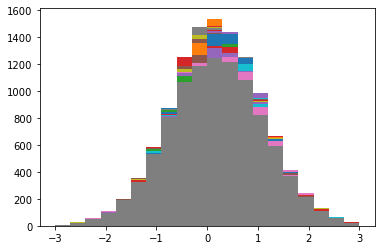

In [5]:
%%time


for di in range( n_input_dirs ) :
    
    in_dir = input_dirs[di]
    
    print('\n\n ====== Input dir: %s :  %s' % (in_dir, input_names[di] ) )
    print('    Unfolding type: %s ,   detector resolution:  %.2f' % (input_lhr_type[di], input_det_res[di]))
    
    with open( '%s/train-and-true-samples.npy' % in_dir, 'rb') as f :
        train_pts = np.load(f)
        train_det_pts = np.load(f)
        true_pts = np.load(f)
        true_det_pts = np.load(f)

    print('\n\n')
    print(' shape of train_pts:  %s' % str(train_pts.shape))
    print(' shape of true_pts:   %s' % str(true_pts.shape))

    
    with open( "%s/omnifold-output-weights.npy" % in_dir,'rb') as f :
        main_sample_omnifold_weights = np.load(f)

    main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

    print('\n\n')
    print(' shape of main_sample_omnifold_weights: %s' % str(main_sample_omnifold_weights.shape))

    
    unfolded_hist,hist_bin_edges,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )

    hist_bin_centers = np.zeros( hist_nbins )
    for bi in range(hist_nbins) :
        hist_bin_centers[bi] = 0.5*(hist_bin_edges[bi] + hist_bin_edges[bi+1])    
    
    bin_width = hist_bin_edges[1] - hist_bin_edges[0]
    
    weight_sum = np.sum( main_sample_omnifold_weights )
    print('\n\n Sum of ominfold weights:  %.3f' % weight_sum )
    
    mean_cov = calc_mean_cov( main_sample_omnifold_weights, 0, 0 )
    
    print( '\n Simple calculation of model pars:     mean = %.5f,     sig2 = %.5f' %
         (mean_cov['mean_x1'], mean_cov['cov_x1x2']))

    
    
    n_samples = 0

    for fi in range(5000) :

        fname = '%s/bootstrap-weights-%03d.npy' % (in_dir, fi)

        if exists(fname) :
            n_samples = n_samples + 1

    print("\n Found %d bootstrap samples.\n\n" % n_samples )    
    

    #--
    
    boot_hist_content = np.zeros( shape=(n_samples, hist_nbins))


    simple_calc_mean = np.zeros( n_samples )
    simple_calc_cov  = np.zeros( n_samples )


    for bi in range(n_samples) :

        #boot_hist_content.append()

        fname = '%s/bootstrap-weights-%03d.npy' % (in_dir, bi)

        if not exists(fname) :  
            print('\n\n *** Missing %s' % fname )
            continue

        with open(fname,'rb') as f :

            final_push_weights_scaled = np.load(f)
            print(' boot %3d weights: ' % bi, end='')
            print( final_push_weights_scaled)

            hist_content,_,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=final_push_weights_scaled, range=[hist_xlow, hist_xhigh] )

            boot_hist_content[bi,:] = hist_content


            mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )

            simple_calc_mean[bi] = mean_cov['mean_x1']
            simple_calc_cov[bi]  = mean_cov['cov_x1x2']
    

    #--

    simple_calc_ave_mean = np.mean( simple_calc_mean )
    simple_calc_ave_mean2 = np.mean( simple_calc_mean * simple_calc_mean )
    simple_calc_rms_mean = np.sqrt( simple_calc_ave_mean2 - simple_calc_ave_mean * simple_calc_ave_mean )

    
    simple_calc_ave_sig2 = np.mean( simple_calc_cov )
    simple_calc_ave_sig22 = np.mean( simple_calc_cov * simple_calc_cov )
    simple_calc_rms_sig2 = np.sqrt( simple_calc_ave_sig22 - simple_calc_ave_sig2 * simple_calc_ave_sig2 )
      
    
    #--
    
    hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
    hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

    for bi in range(hist_nbins) :

        for bj in range( hist_nbins ) :

            ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
            cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )

            hist_corr_mat[bi,bj] = ccm[0,1]

            hist_cov_mat[bi,bj] = cvm[0,1]

            if bi == bj : hist_cov_mat[bi,bj] = hist_cov_mat[bi,bj] + diagonal_constant

    #--
    
    hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )
    
    #--
    
    hist_cov_mat_diagonal = np.copy( hist_cov_mat )
    for bi in range(hist_nbins) :
        for bj in range(hist_nbins) :
            if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.
            
    hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )
    print(hist_cov_inv_diagonal)        
    
    #--
    

    chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
    chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

    chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
    chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

    chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
    chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

    chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
    chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



    for si in range( len(boot_hist_content) ) :

        # Initialize Minuit and set up fit:
        theta = 1
        mu = 0.2
        sigma2 = 0.81
        #fitType = 'full cov'

        parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
        parname = ['theta', 'mu', 'sigma2']
        parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
        parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
        parfix  = [False, False, False]            # change to fix/free param.
        parlim  = [(0.5, 1.5), (None, None), (0., None)]

        chisq = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_pinv, fitType)
        chisq_diag = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_inv_diagonal, fitType)


        m = Minuit(chisq, parin, name=parname)
        m.errors = parstep
        m.fixed = parfix
        m.limits = parlim
        m.errordef = 1.0                      # errors from chi2 = chi2min + 1


        m_diag = Minuit(chisq_diag, parin, name=parname)
        m_diag.errors = parstep
        m_diag.fixed = parfix
        m_diag.limits = parlim
        m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    


        # do the fit, get errors, extract results
        m.migrad()                                        # minimize -logL
        parhat = m.values                                 # max-likelihood estimates
        sigma_parhat = m.errors                           # standard deviations
        cov = m.covariance                                # covariance matrix
        rho = m.covariance.correlation()                  # correlation coeffs.

        m_diag.migrad()                                        # minimize -logL
        parhat_diag = m_diag.values                                 # max-likelihood estimates
        sigma_parhat_diag = m_diag.errors                           # standard deviations
        cov_diag = m_diag.covariance                                # covariance matrix
        rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.


        chi2_fit_mu_val[si] = parhat[1]
        chi2_fit_mu_err[si] = sigma_parhat[1]

        chi2_fit_sig2_val[si] = parhat[2]
        chi2_fit_sig2_err[si] = sigma_parhat[2]


        chi2_fit_diag_mu_val[si] = parhat_diag[1]
        chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

        chi2_fit_diag_sig2_val[si] = parhat_diag[2]
        chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]


        print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
              (si, 
               parhat[1], sigma_parhat[1],
               parhat_diag[1], sigma_parhat_diag[1],
               parhat[2], sigma_parhat[2],
               parhat_diag[2], sigma_parhat_diag[2],
              )
             )

    #--


    mean_mu = np.mean( chi2_fit_mu_val )
    mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
    rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

    mean_sig2 = np.mean( chi2_fit_sig2_val )
    mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
    rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

    mean_mu_fit_err = np.mean( chi2_fit_mu_err )
    mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )
    
    
    mean_mu_fit_err2 = np.mean( chi2_fit_mu_err * chi2_fit_mu_err )
    mean_mu_fit_err_rms = np.sqrt( mean_mu_fit_err2 - mean_mu_fit_err * mean_mu_fit_err )

    mean_sig2_fit_err2 = np.mean( chi2_fit_sig2_err * chi2_fit_sig2_err )
    mean_sig2_fit_err_rms = np.sqrt( mean_sig2_fit_err2 - mean_sig2_fit_err * mean_sig2_fit_err )
    
    
    



    mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
    mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
    rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

    mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
    mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
    rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

    mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
    mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )


    
    mean_mu_fit_err2_diag = np.mean( chi2_fit_diag_mu_err * chi2_fit_diag_mu_err )
    mean_mu_fit_err_rms_diag = np.sqrt( mean_mu_fit_err2_diag - mean_mu_fit_err_diag * mean_mu_fit_err_diag )

    mean_sig2_fit_err2_diag = np.mean( chi2_fit_diag_sig2_err * chi2_fit_diag_sig2_err )
    mean_sig2_fit_err_rms_diag = np.sqrt( mean_sig2_fit_err2_diag - mean_sig2_fit_err_diag * mean_sig2_fit_err_diag )

    
    
    
    
    


    print('\n\n')
    print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
          (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
    print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
          (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
    print('\n\n')

    
    
    #-- Model mean
    
    pi = 0
    
    ii = 0
    results_inference_mean[di, ii, pi] = simple_calc_ave_mean
    results_rms[di, ii, pi] = simple_calc_rms_mean
    
    ii = 1
    results_inference_mean[di, ii, pi] = mean_mu
    results_fit_err[di, ii, pi] = mean_mu_fit_err
    results_rms[di, ii, pi] = rms_mu
    
    ii = 2
    results_inference_mean[di, ii, pi] = mean_mu_diag
    results_fit_err[di, ii, pi] = mean_mu_fit_err_diag
    results_rms[di, ii, pi] = rms_mu_diag
    

    
    #-- stat err on above
    
    ii = 0
    results_inference_mean_stat_err[di, ii, pi] = simple_calc_rms_mean / np.sqrt( n_samples )    
    results_rms_stat_err[di, ii, pi] = simple_calc_rms_mean / np.sqrt( 2 * n_samples )
    
    ii = 1
    results_inference_mean_stat_err[di, ii, pi] = rms_mu / np.sqrt( n_samples )
    results_fit_err_stat_err[di, ii, pi] = mean_mu_fit_err_rms / np.sqrt( n_samples )
    results_rms_stat_err[di, ii, pi] = rms_mu / np.sqrt( 2 * n_samples )
    
    
    ii = 2
    results_inference_mean_stat_err[di, ii, pi] = rms_mu_diag / np.sqrt( n_samples )
    results_fit_err_stat_err[di, ii, pi] = mean_mu_fit_err_rms_diag / np.sqrt( n_samples )
    results_rms_stat_err[di, ii, pi] = rms_mu_diag / np.sqrt( 2 * n_samples ) 
    
    
    
    
    
    
    
    
    
    #-- Model sig2
    
    pi = 1
    
    ii = 0
    results_inference_mean[di, ii, pi] = simple_calc_ave_sig2
    results_rms[di, ii, pi] = simple_calc_rms_sig2
    
    ii = 1
    results_inference_mean[di, ii, pi] = mean_sig2
    results_fit_err[di, ii, pi] = mean_sig2_fit_err
    results_rms[di, ii, pi] = rms_sig2
    
    ii = 2
    results_inference_mean[di, ii, pi] = mean_sig2_diag
    results_fit_err[di, ii, pi] = mean_sig2_fit_err_diag
    results_rms[di, ii, pi] = rms_sig2_diag

    
    
    #-- stat err on above
    
    ii = 0
    results_inference_mean_stat_err[di, ii, pi] = simple_calc_rms_sig2 / np.sqrt( n_samples )    
    results_rms_stat_err[di, ii, pi] = simple_calc_rms_sig2 / np.sqrt( 2 * n_samples )
    
    ii = 1
    results_inference_mean_stat_err[di, ii, pi] = rms_sig2 / np.sqrt( n_samples )
    results_fit_err_stat_err[di, ii, pi] = mean_sig2_fit_err_rms / np.sqrt( n_samples )
    results_rms_stat_err[di, ii, pi] = rms_sig2 / np.sqrt( 2 * n_samples )
    
    
    ii = 2
    results_inference_mean_stat_err[di, ii, pi] = rms_sig2_diag / np.sqrt( n_samples )
    results_fit_err_stat_err[di, ii, pi] = mean_sig2_fit_err_rms_diag / np.sqrt( n_samples )
    results_rms_stat_err[di, ii, pi] = rms_sig2_diag / np.sqrt( 2 * n_samples ) 
  

    #--

    
    
    
    
    
    
    
    
    
    
    
    
    have_fits = False

    if exists( "%s/fit-results.npy" % in_dir ) :
        have_fits = True
        print("\n\n Have fit results file.\n\n")
        
    if have_fits :
        
        ndim = 1

        with open( '%s/fit-results.npy' % in_dir, 'rb' ) as f :
            fit_results_mean_val = np.load(f, allow_pickle=True )
            fit_results_mean_err = np.load(f, allow_pickle=True )
            fit_results_cov_val = np.load(f, allow_pickle=True )
            fit_results_cov_err = np.load(f, allow_pickle=True )        


        ave_fit_err_mean = np.zeros( ndim )

        ave_fit_err_cov = np.zeros( shape=(ndim,ndim) )

        for fi in range(ndim) :

            ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])

            print( '%d : ave fit error, mean :  %8.4f' % (fi, ave_fit_err_mean[fi]))

        for fi1 in range(ndim) :
            for fi2 in range(fi1,ndim) :


                ave_fit_err_cov[fi1,fi2] = np.mean( fit_results_cov_err[fi1,fi2,:])

                print( 'fi1, fi2 : %d, %d    ave fit error, cov : %8.4f' % (fi1,fi2, ave_fit_err_cov[fi1,fi2]))

                
        ii = 0
        
        pi = 0
        results_fit_err[di, ii, pi] = ave_fit_err_mean[0]

        pi = 1
        results_fit_err[di, ii, pi] = ave_fit_err_cov[0,0]
                

    print('\n ====== End of this dir: %s :  %s' % (in_dir, input_names[di] ) )
                

In [6]:
results_inference_mean

array([[[0.20026573, 0.8114612 ],
        [0.18974899, 0.79692633],
        [0.19966688, 0.80983857]],

       [[0.19842436, 0.81168591],
        [0.19815617, 0.80828264],
        [0.19836411, 0.81149664]],

       [[0.19959532, 0.81397521],
        [0.19260693, 0.84086238],
        [0.19874492, 0.81453909]],

       [[0.20171016, 0.84165302],
        [0.20028671, 0.83735196],
        [0.20219442, 0.83934314]],

       [[0.19975565, 0.81219706],
        [0.18930094, 0.79785586],
        [0.19934966, 0.81077666]],

       [[0.20026437, 0.81256706],
        [0.20107001, 0.80621641],
        [0.20120046, 0.8113564 ]],

       [[0.19979314, 0.81302739],
        [0.20000249, 0.81542363],
        [0.20032651, 0.81735912]],

       [[0.19771217, 0.83710992],
        [0.1963281 , 0.83306651],
        [0.19969606, 0.83832335]]])

In [7]:
results_fit_err

array([[[0.00899085, 0.0114546 ],
        [0.00887507, 0.011744  ],
        [0.00664988, 0.00881491]],

       [[0.00899161, 0.01145885],
        [0.00938047, 0.01372459],
        [0.00661132, 0.00882895]],

       [[0.00900695, 0.01149407],
        [0.01051628, 0.0166526 ],
        [0.00605116, 0.00819093]],

       [[0.00916253, 0.01189071],
        [0.0117229 , 0.0173522 ],
        [0.00536836, 0.00734724]],

       [[0.00900401, 0.0114754 ],
        [0.01118106, 0.0149322 ],
        [0.00581733, 0.00753756]],

       [[0.00900504, 0.01148199],
        [0.01114499, 0.01412657],
        [0.0060846 , 0.00829583]],

       [[0.00900316, 0.01147379],
        [0.01213193, 0.0169209 ],
        [0.00673434, 0.00933944]],

       [[0.00913968, 0.01181997],
        [0.01307165, 0.01859167],
        [0.00717865, 0.01013065]]])

In [8]:
results_rms

array([[[0.00899521, 0.01174102],
        [0.00876808, 0.01161011],
        [0.00915174, 0.01191986]],

       [[0.00929799, 0.01252469],
        [0.00934125, 0.01344759],
        [0.00953987, 0.01290885]],

       [[0.01065782, 0.01428753],
        [0.01043763, 0.01688269],
        [0.01085184, 0.01517708]],

       [[0.01177861, 0.01687584],
        [0.01169143, 0.01706559],
        [0.01208619, 0.01752806]],

       [[0.01131814, 0.01386989],
        [0.01109661, 0.01603571],
        [0.0115262 , 0.01420875]],

       [[0.01122775, 0.014154  ],
        [0.0111252 , 0.0142311 ],
        [0.01177096, 0.01514623]],

       [[0.01220829, 0.01620525],
        [0.01211766, 0.01735603],
        [0.01323343, 0.01782066]],

       [[0.01311604, 0.01884462],
        [0.01308757, 0.01852772],
        [0.01393863, 0.01976377]]])

In [9]:
results_inference_mean_stat_err 

array([[[0.00040228, 0.00052507],
        [0.00039212, 0.00051922],
        [0.00040928, 0.00053307]],

       [[0.00041582, 0.00056012],
        [0.00041775, 0.00060139],
        [0.00042664, 0.0005773 ]],

       [[0.00047663, 0.00063896],
        [0.00046678, 0.00075502],
        [0.00048531, 0.00067874]],

       [[0.00052676, 0.00075471],
        [0.00052286, 0.0007632 ],
        [0.00054051, 0.00078388]],

       [[0.00035791, 0.0004386 ],
        [0.00035091, 0.00050709],
        [0.00036449, 0.00044932]],

       [[0.00035505, 0.00044759],
        [0.00035181, 0.00045003],
        [0.00037223, 0.00047897]],

       [[0.00038606, 0.00051245],
        [0.00038319, 0.00054885],
        [0.00041848, 0.00056354]],

       [[0.00041477, 0.00059592],
        [0.00041387, 0.0005859 ],
        [0.00044078, 0.00062499]]])

In [10]:
results_fit_err_stat_err

array([[[0.00000000e+00, 0.00000000e+00],
        [2.94288865e-07, 5.62561633e-06],
        [7.10495365e-07, 3.80589611e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [9.02902414e-07, 8.03500245e-06],
        [6.56923483e-07, 4.47854518e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [1.04005816e-06, 1.09832366e-05],
        [1.04934625e-06, 4.51991432e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [8.98276515e-07, 1.37228618e-05],
        [9.02661480e-07, 3.62251284e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [2.64472146e-06, 1.06879029e-05],
        [1.57667735e-06, 3.00448728e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [2.69725703e-06, 8.24481362e-06],
        [1.96593484e-06, 4.22318649e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [3.01512155e-06, 9.70338866e-06],
        [2.38832450e-06, 5.26840974e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [3.07799472e-06, 1.11300474e-05],
        [2.80338907e

In [11]:
results_rms_stat_err

array([[[0.00028445, 0.00037128],
        [0.00027727, 0.00036714],
        [0.0002894 , 0.00037694]],

       [[0.00029403, 0.00039607],
        [0.0002954 , 0.00042525],
        [0.00030168, 0.00040821]],

       [[0.00033703, 0.00045181],
        [0.00033007, 0.00053388],
        [0.00034317, 0.00047994]],

       [[0.00037247, 0.00053366],
        [0.00036972, 0.00053966],
        [0.0003822 , 0.00055429]],

       [[0.00025308, 0.00031014],
        [0.00024813, 0.00035857],
        [0.00025773, 0.00031772]],

       [[0.00025106, 0.00031649],
        [0.00024877, 0.00031822],
        [0.00026321, 0.00033868]],

       [[0.00027299, 0.00036236],
        [0.00027096, 0.00038809],
        [0.00029591, 0.00039848]],

       [[0.00029328, 0.00042138],
        [0.00029265, 0.00041429],
        [0.00031168, 0.00044193]]])

In [12]:
with open( 'inference-analysis-results.npy', 'wb' ) as f :
    np.save( f, results_inference_mean )
    np.save( f, results_fit_err )
    np.save( f, results_rms )
    np.save( f, results_inference_mean_stat_err )
    np.save( f, results_fit_err_stat_err )
    np.save( f, results_rms_stat_err )    